# Прогнозирование оттока клиентов сети фитнес-центров

**Заказчик**

Сеть фитнес-центров «Культурист-датасаентист»

**Цель проекта**

Провести анализ и подготовить план действий по удержанию клиентов:   


* научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;  

* сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;  

* проанализировать основные признаки, наиболее сильно влияющие на отток;   

* сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:  
1) выделить целевые группы клиентов;   
2) предложить меры по снижению оттока;  
3) определить другие особенности взаимодействия с клиентами.  


**Входные данные**

Файл, который содержит данные на месяц до оттока и факт оттока на определённый месяц (файл `gym_churn.csv`)


Данные клиента за предыдущий до проверки факта оттока месяц:    

`gender` — пол;   
`Near_Location` — проживание или работа в районе, где находится фитнес-центр;   
`Partner` — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);    
`Promo_friends` — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);    
`Phone` — наличие контактного телефона;    
`Age` — возраст;    
`Lifetime` — время с момента первого обращения в фитнес-центр (в месяцах).    


Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:    

`Contract_period` — длительность текущего действующего абонемента (месяц, 6 месяцев, год);    
`Month_to_end_contract` — срок до окончания текущего действующего абонемента (в месяцах);   
`Group_visits` — факт посещения групповых занятий;   
`Avg_class_frequency_total` — средняя частота посещений в неделю за все время с начала действия абонемента;   
`Avg_class_frequency_current_month` — средняя частота посещений в неделю за предыдущий месяц;    
`Avg_additional_charges_total` — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон;       
`Churn` — факт оттока в текущем месяце.    


 
**Ход исследования**

Исследование пройдёт в пять этапов:

*    Обзор  и предобработка данных;
*    Исследовательский анализ данных (EDA);    
*    Построение модель прогнозирования оттока клиентов;
*    Кластеризация клиентов;
*    Выводы и базовые рекомендации.


## Обзор и предобработка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings; warnings.filterwarnings(action = 'ignore')

from plotly import graph_objects as go
from IPython.display import set_matplotlib_formats
from pandas.plotting import register_matplotlib_converters
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler
register_matplotlib_converters()

In [2]:
# снимаем ограничение на количество столбцов
pd.set_option('display.max_columns', 50)

# снимаем ограничение на ширину столбцов
pd.set_option('display.max_colwidth', 120)

# игнорируем предупреждения
pd.set_option('chained_assignment', 'warn')
warnings.simplefilter(action='ignore', category=FutureWarning)

# выставляем ограничение на показ знаков после запятой
pd.options.display.float_format = '{:,.2f}'.format

# устанавливаем стиль графиков
sns.set(rc={'figure.dpi':200, 'savefig.dpi':300})   
sns.set_context('notebook')     

In [3]:
# чтение файлов с данными и сохранение в df

try:
    data = pd.read_csv('/datasets/gym_churn.csv')
except:
    data = pd.read_csv('gym_churn.csv')

In [4]:
data.info()
display(data.head(5))
print('Явных дубликатов:', data.duplicated().sum(), 'Доля дубликатов:', data.duplicated().sum() / len(data))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.23,5.00,3,0.02,0.00,0
1,0,1,0,0,1,12,1,31,113.20,12.00,7,1.92,1.91,0
2,0,1,1,0,1,1,0,28,129.45,1.00,2,1.86,1.74,0
3,0,1,1,1,1,12,1,33,62.67,12.00,2,3.21,3.36,0
4,1,1,1,1,1,1,0,26,198.36,1.00,3,1.11,1.12,0


Явных дубликатов: 0 Доля дубликатов: 0.0


In [5]:
# приведем названия заголовков к нижнему регистру, изменим названия на более удобные:

data.columns = data.columns.str.lower()

**Выводы**

Таблица содержит информацию о 4 тысячах записей. Пропусков и явных дубликатов нет. Данные обезличенные.

## Исследовательский анализ данных (EDA)

In [6]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,"4,000.00",0.51,0.50,0.00,0.00,1.00,1.00,1.00
near_location,"4,000.00",0.85,0.36,0.00,1.00,1.00,1.00,1.00
partner,"4,000.00",0.49,0.50,0.00,0.00,0.00,1.00,1.00
promo_friends,"4,000.00",0.31,0.46,0.00,0.00,0.00,1.00,1.00
phone,"4,000.00",0.90,0.30,0.00,1.00,1.00,1.00,1.00
contract_period,"4,000.00",4.68,4.55,1.00,1.00,1.00,6.00,12.00
group_visits,"4,000.00",0.41,0.49,0.00,0.00,0.00,1.00,1.00
age,"4,000.00",29.18,3.26,18.00,27.00,29.00,31.00,41.00
avg_additional_charges_total,"4,000.00",146.94,96.36,0.15,68.87,136.22,210.95,552.59
month_to_end_contract,"4,000.00",4.32,4.19,1.00,1.00,1.00,6.00,12.00


Итак, что мы можем сказать предварительно:    
1. мужчины и женщины в файле представлены примерно поровну, возрастной диапазон от 18 до 41 года, в среднем - 29 лет;
2. половина посетителей являются сотрудниками компаний-партнёров клуба, а треть - пришла по акции;   
3. подавляющее большинство выбрало клуб из-за близости к месту проживания или работы (85%);   
4. телефон не указан у 10% посетителей;   
5. у более половины посетителей абонемент на один месяц посещения;    
6. средняя суммарная выручка от других услуг фитнес-центра - 147уе.;   
7. среднее время жизни клиента - почти 4 месяца;   
8. отток - 27%.  

___
Посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток (1)  и тех, кто остался (0).

In [7]:
data.groupby('churn').agg('mean').T

churn,0,1
gender,0.51,0.51
near_location,0.87,0.77
partner,0.53,0.36
promo_friends,0.35,0.18
phone,0.90,0.90
contract_period,5.75,1.73
group_visits,0.46,0.27
age,29.98,26.99
avg_additional_charges_total,158.45,115.08
month_to_end_contract,5.28,1.66


1. пол распределился равномерно;   
2. близость к жилью и работе уменьшает отток, но не очень сильно(87% против 77%).
3. так же, среди клиентов  из компаний-партнёров клуба доля оставшихся выше (53% против 36%).
4. в отток, в основном попадают, клиенты с месячным абонементом, а те, кто покупают абонементы на более длительный срок,  - продолжают посещение;
5. клиенты, попавшие в отток, реже посещали групповые занятия, чем оставшиеся (27% против 46%);
6. средний возраст клиентов, попавших в отток, - 27 лет, у оставшихся - 30 лет;
7. средняя суммарная выручка от других услуг фитнес-центра от ушедших в отток клиентов ниже, чем у оставшихся (115 уе. против 158 уе.);
8. средняя частота посещений за весь период у клиентов, попавших в отток, ниже, чем у оставшихся (1.47 против 2 раз в неделю), а средняя частота посещений за последний месяц (1 раз против 2 раз в неделю) ниже в 2 раза.

###  Гистограммы и распределения признаков

При помощи функций построим столбчатые диаграммы для категориальных признаков и гистограммы распределения для числовых признаков, а так же диаграммы размаха.

In [8]:
# функция по отрисовке гистограммы распределения и диаграммы размаха для числовых признаков;
# на входе функии передем параметры: датафрейм, название столбца, по которому строим график, название графика;

def numeric_plots(df, col, title):
    fig, ax = plt.subplots(figsize = (12, 4))
    
    sns.histplot(df[df['churn']==0][col], color = '#EFC87B', ax = plt.subplot(1, 2, 1))
    sns.histplot(df[df['churn']==1][col], label = 'отток', color = '#184562', ax = plt.subplot(1, 2, 1), alpha=.4)
    plt.xlabel('')
    plt.ylabel('')
    plt.legend()
    
    sns.boxplot(y = col, x = 'churn', data = df, ax = plt.subplot(1, 2, 2), palette='Pastel2_r') 
    plt.xlabel('')
    plt.ylabel('')
    plt.xticks(np.arange(2), ('Действующие клиенты', 'Отток'))
    
    fig.suptitle(title + ' (' + col + ')')
    plt.show()

In [9]:
# функия по отрисовке столбчатых диаграмм и диаграммы размаха для категориальных признаков;
# на входе функии передем параметры: датафрейм, название столбца, по которому строим график, название графика;

def categorical_plots(df, col, title):
    fig, ax = plt.subplots(figsize = (12, 4))

    sns.countplot(x = col, hue = 'churn', data = df, ax = plt.subplot(1, 2, 1),  palette='Pastel2')
    plt.ylabel('')
    plt.xlabel('')
    plt.legend() 
    
    gr = df.groupby([col, 'churn']).agg(count=('age', 'count')).reset_index()
    sns.boxplot(x = col, y = 'count', data = gr, ax = plt.subplot(1, 2, 2), palette='Pastel2_r') 
    plt.xlabel('')
    plt.ylabel('')
    
    
    fig.suptitle(title + ' (' + col + ')')
    plt.show()

In [10]:
# Соберём для удобства в DataFrame название колонок и названия графиков:

numeric = pd.DataFrame({'col' : ['age', 'avg_additional_charges_total', 'month_to_end_contract', 'lifetime',
              'avg_class_frequency_total', 'avg_class_frequency_current_month'], 
                        'title' : ['Возраст', 'Сумма дополнительных трат', 'Срок окончания действующего абонемента, мес.', 
              'Время с момента первого обращения, мес.', 'Средняя частота посещений в неделю за весь период', 
              'Средняя частота посещений в неделю за последний месяц']
                       })

categorical = pd.DataFrame({'col' : ['gender', 'near_location', 'partner', 'promo_friends', 
                'phone', 'contract_period', 'group_visits'],
                            'title' : ['Пол', 'Проживание/работа около клуба', 'Сотрудники компании-партнёра', 
                'Клиенты, пришедшие по акции "Приведи друга"', 'Телефон', 'Длительность абонемента, мес', 
                'Посещение групповых программ']
                            })


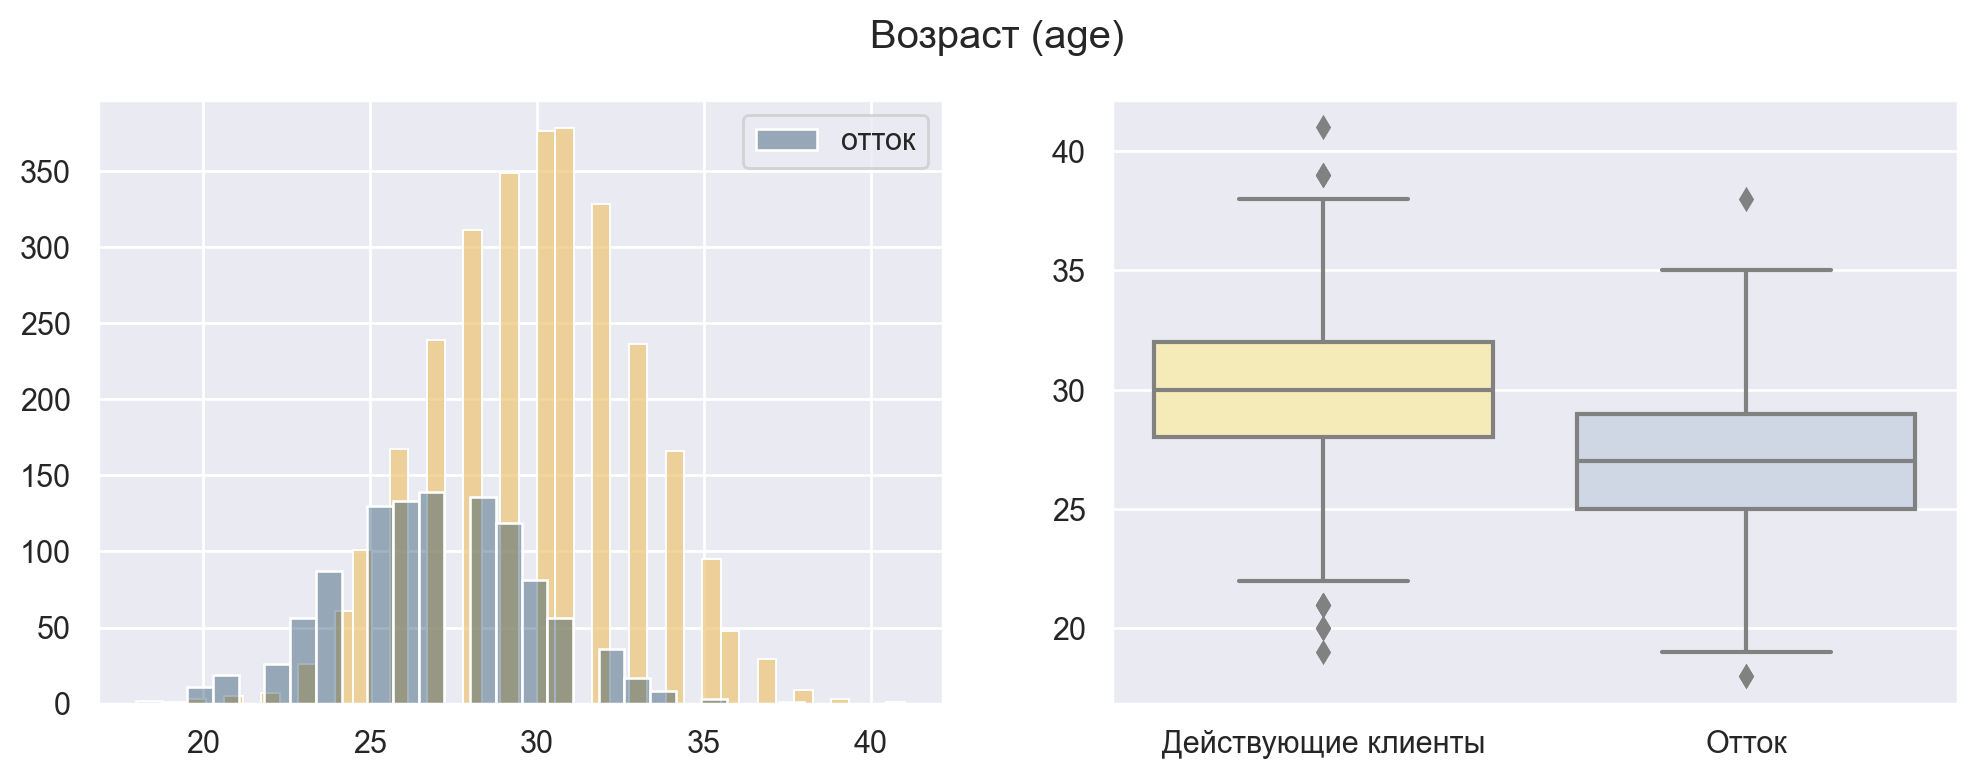

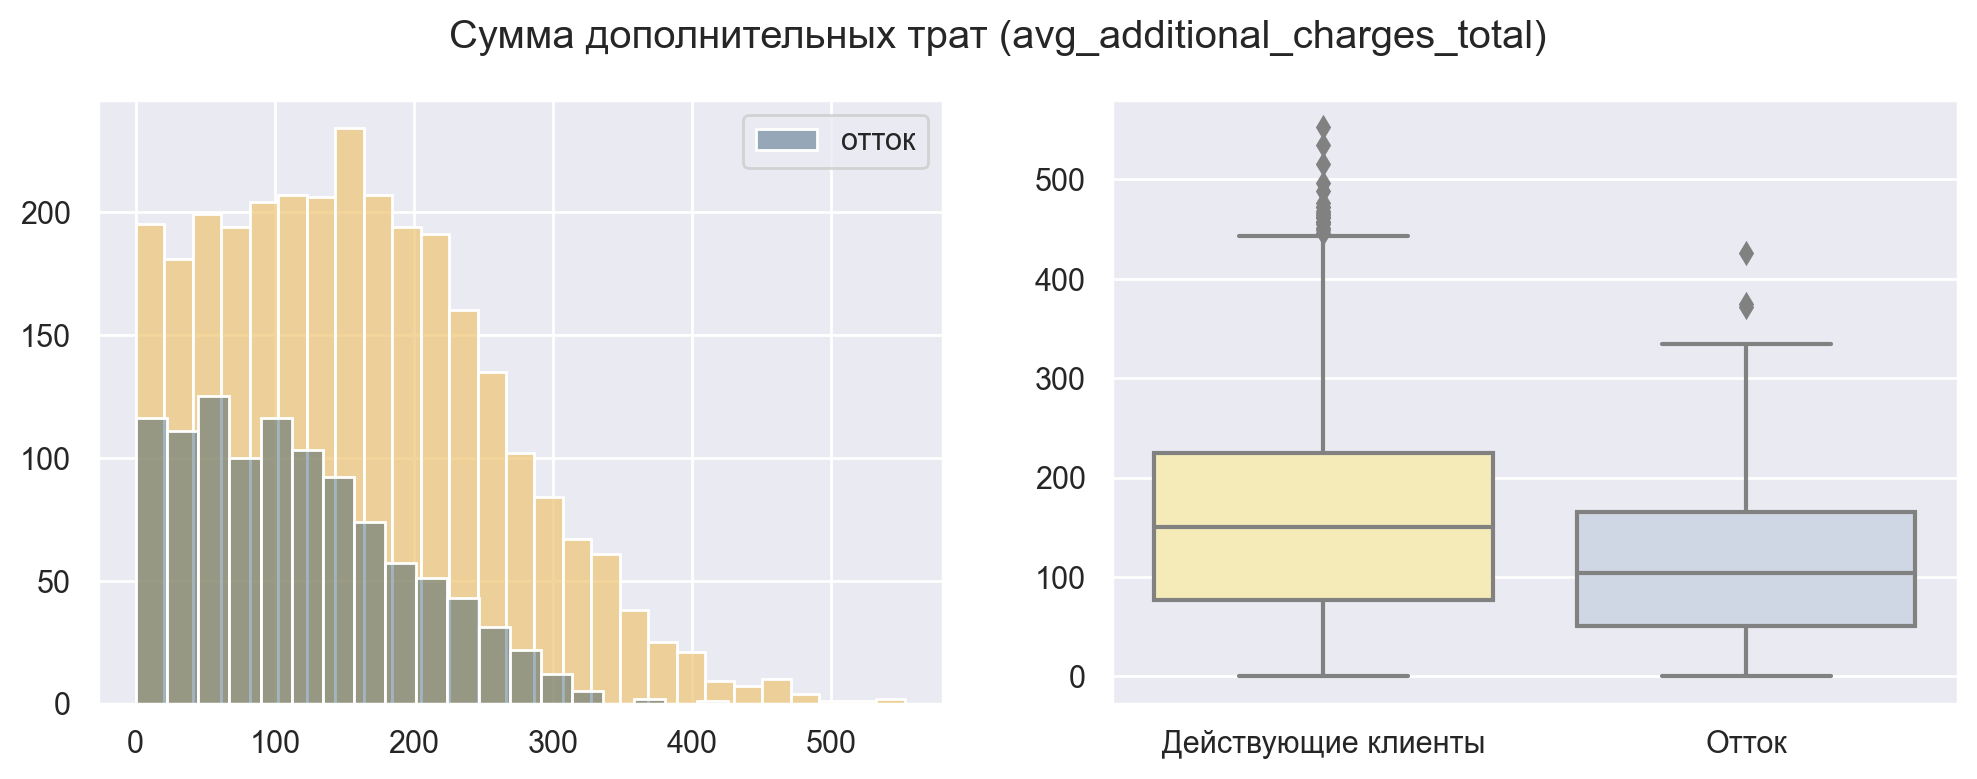

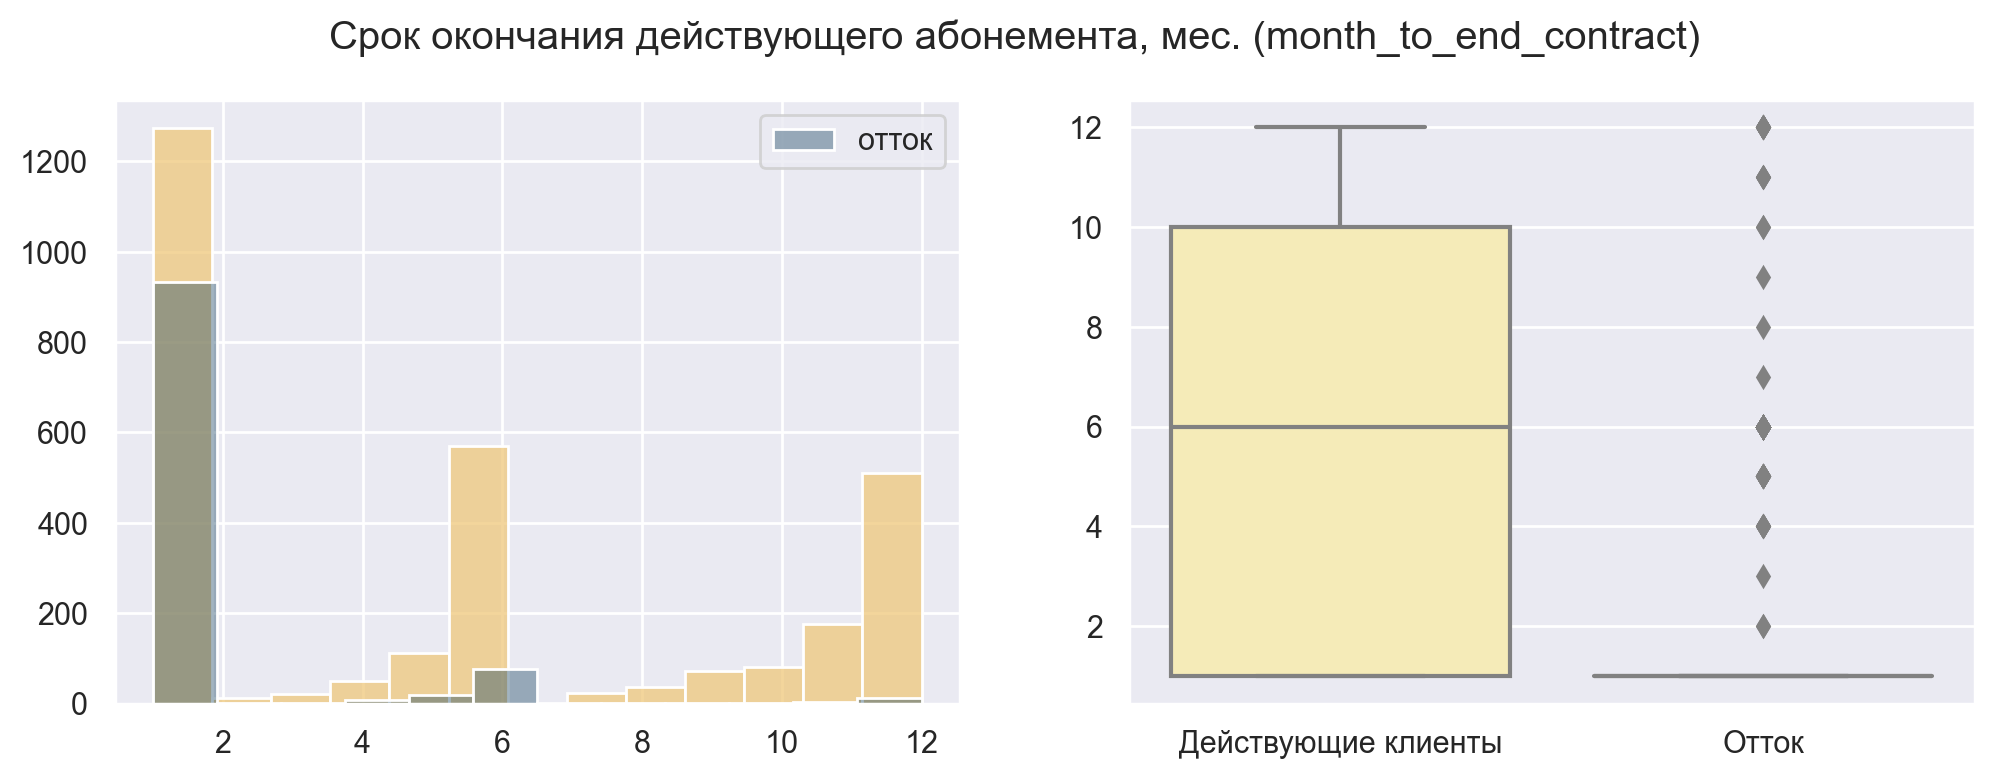

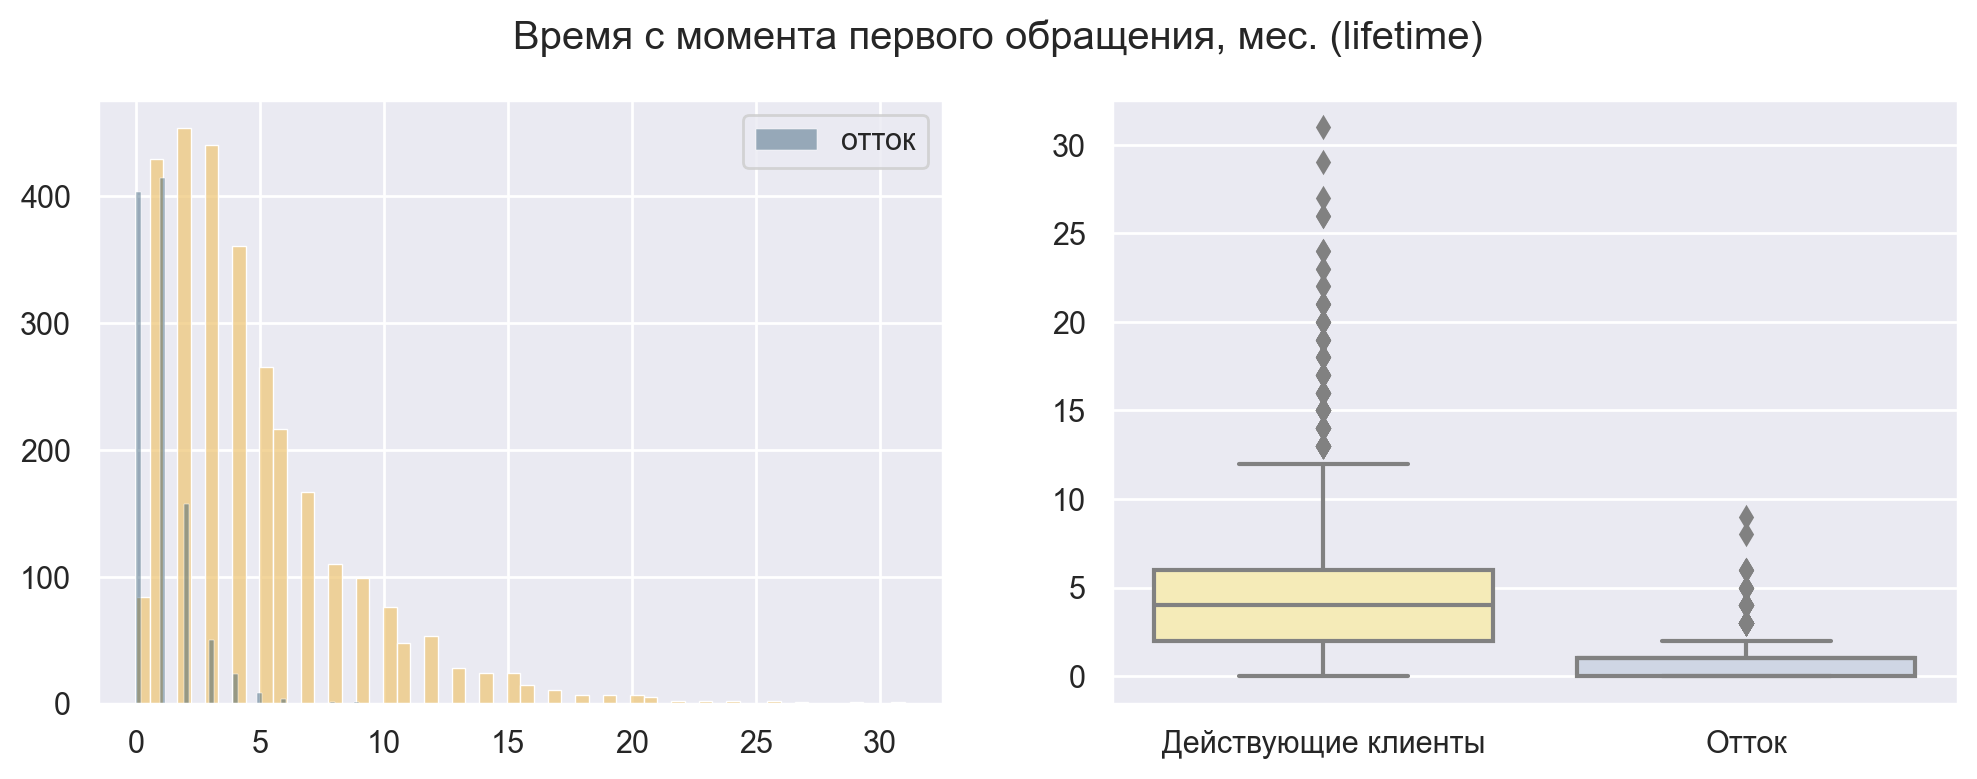

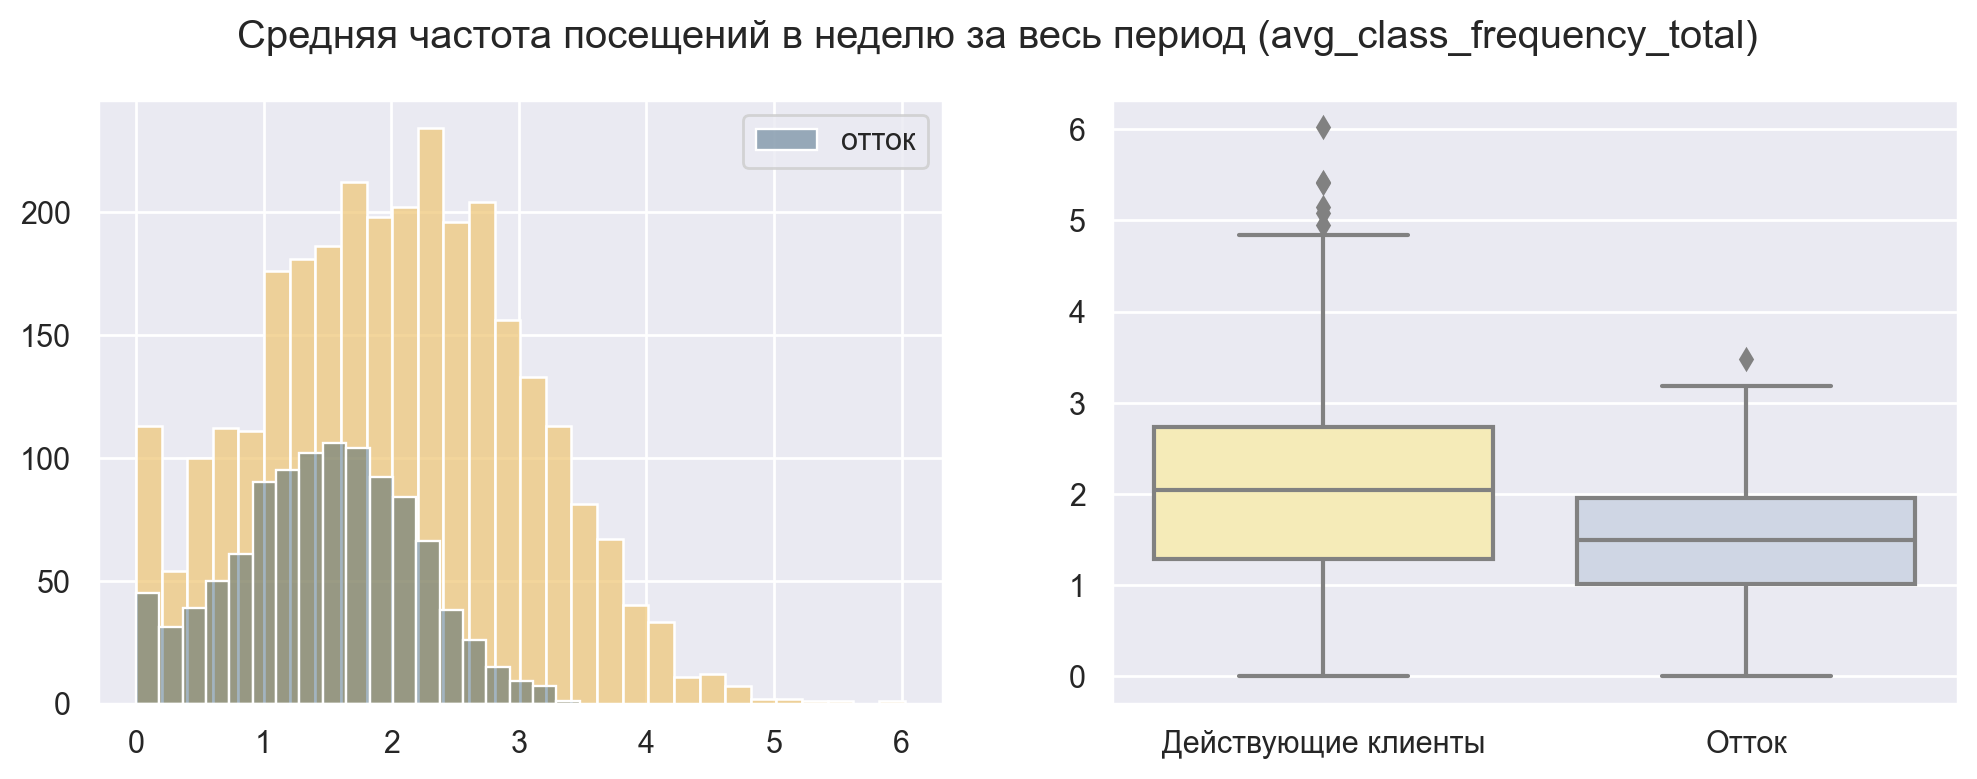

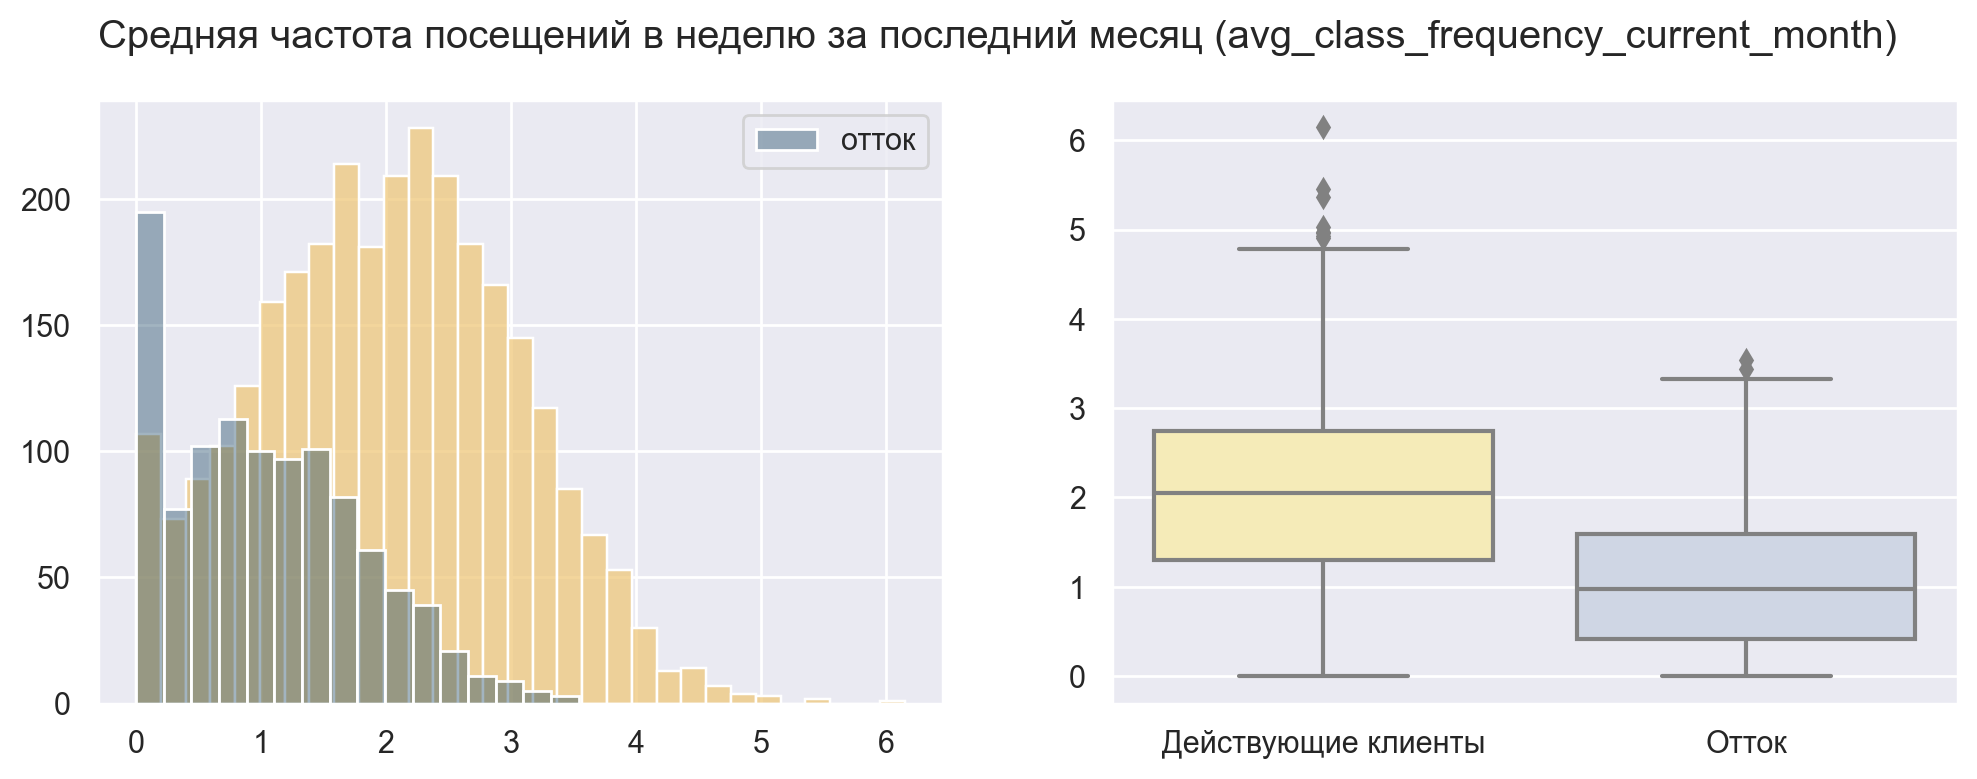

In [11]:
for index, row in numeric.iterrows():
    numeric_plots(data, row[0], row[1])

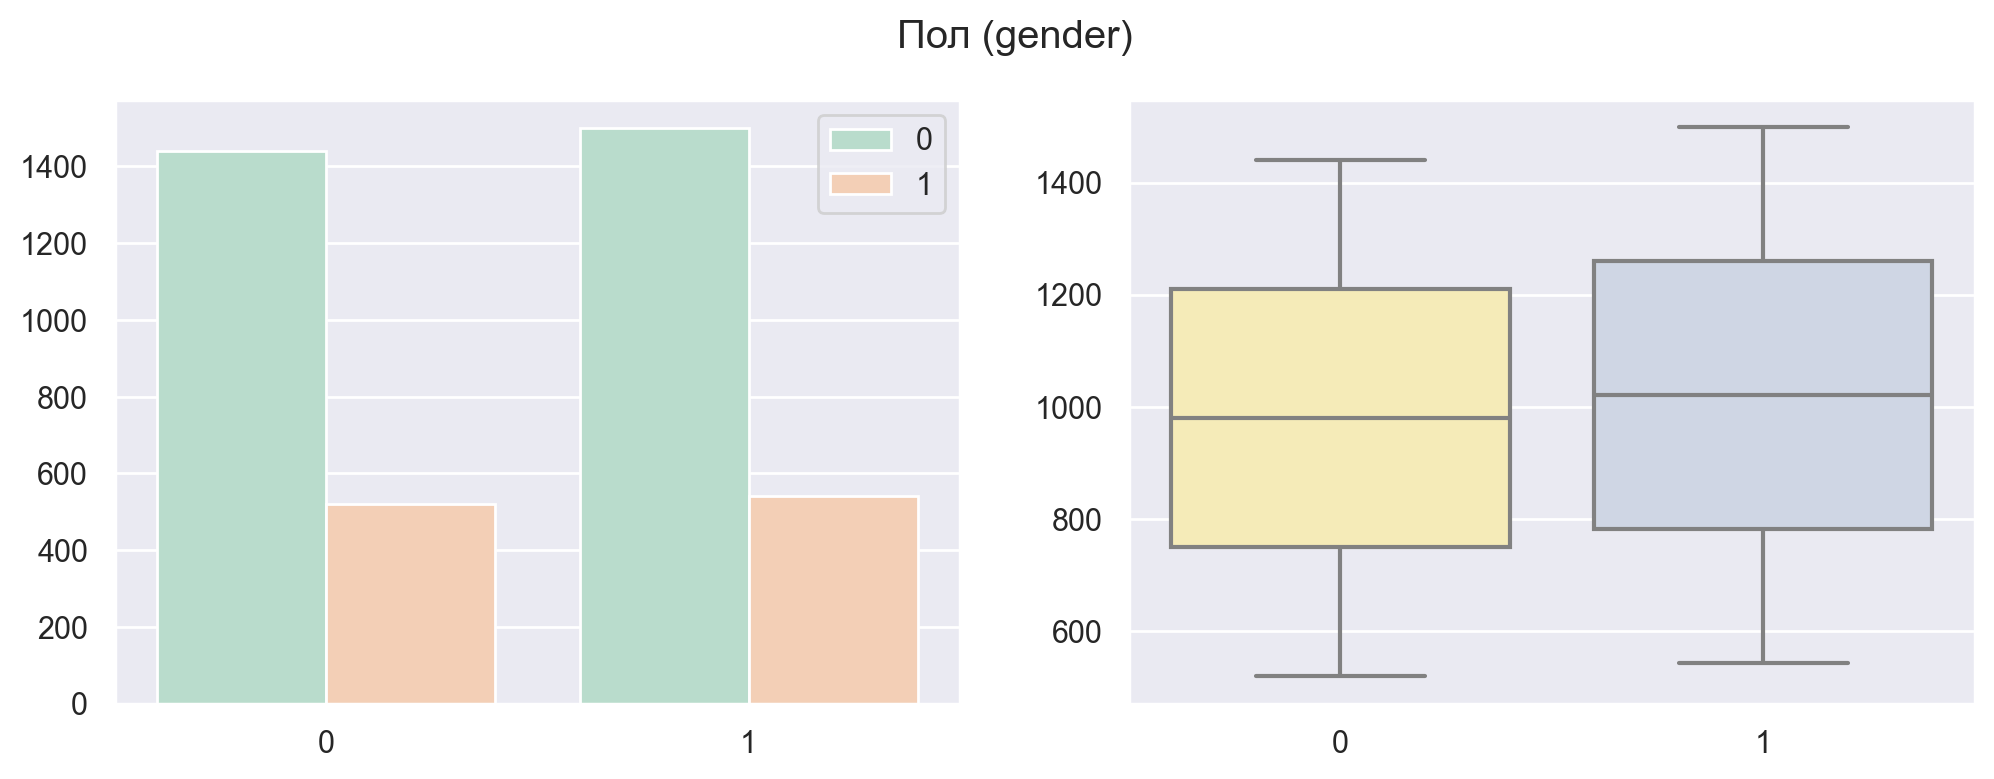

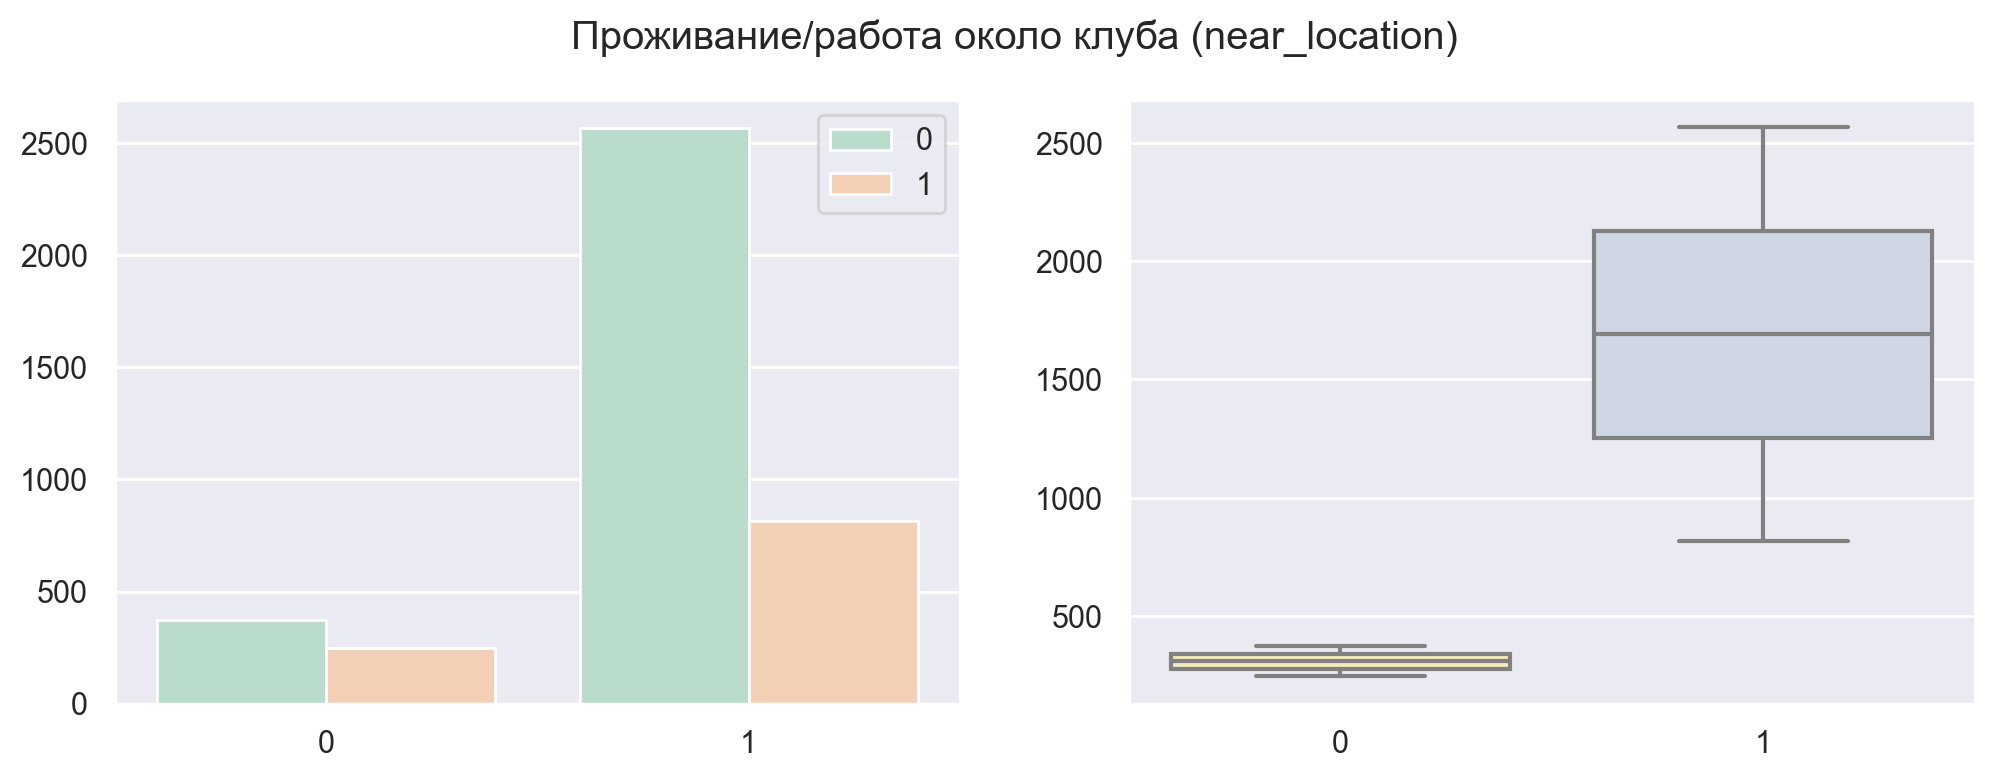

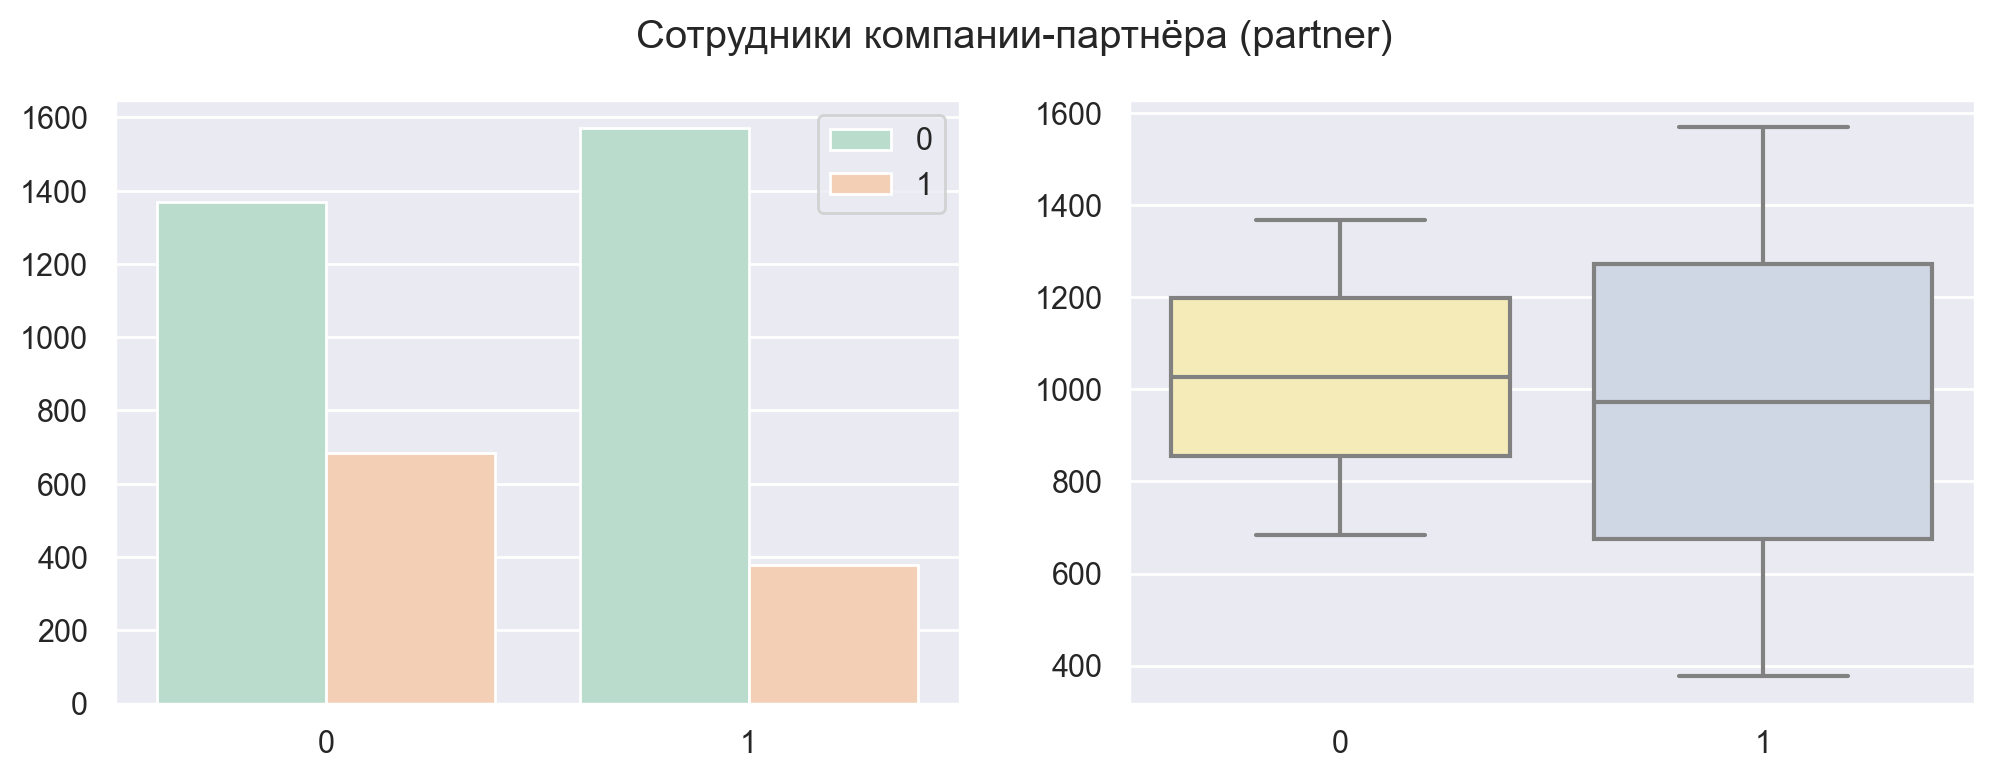

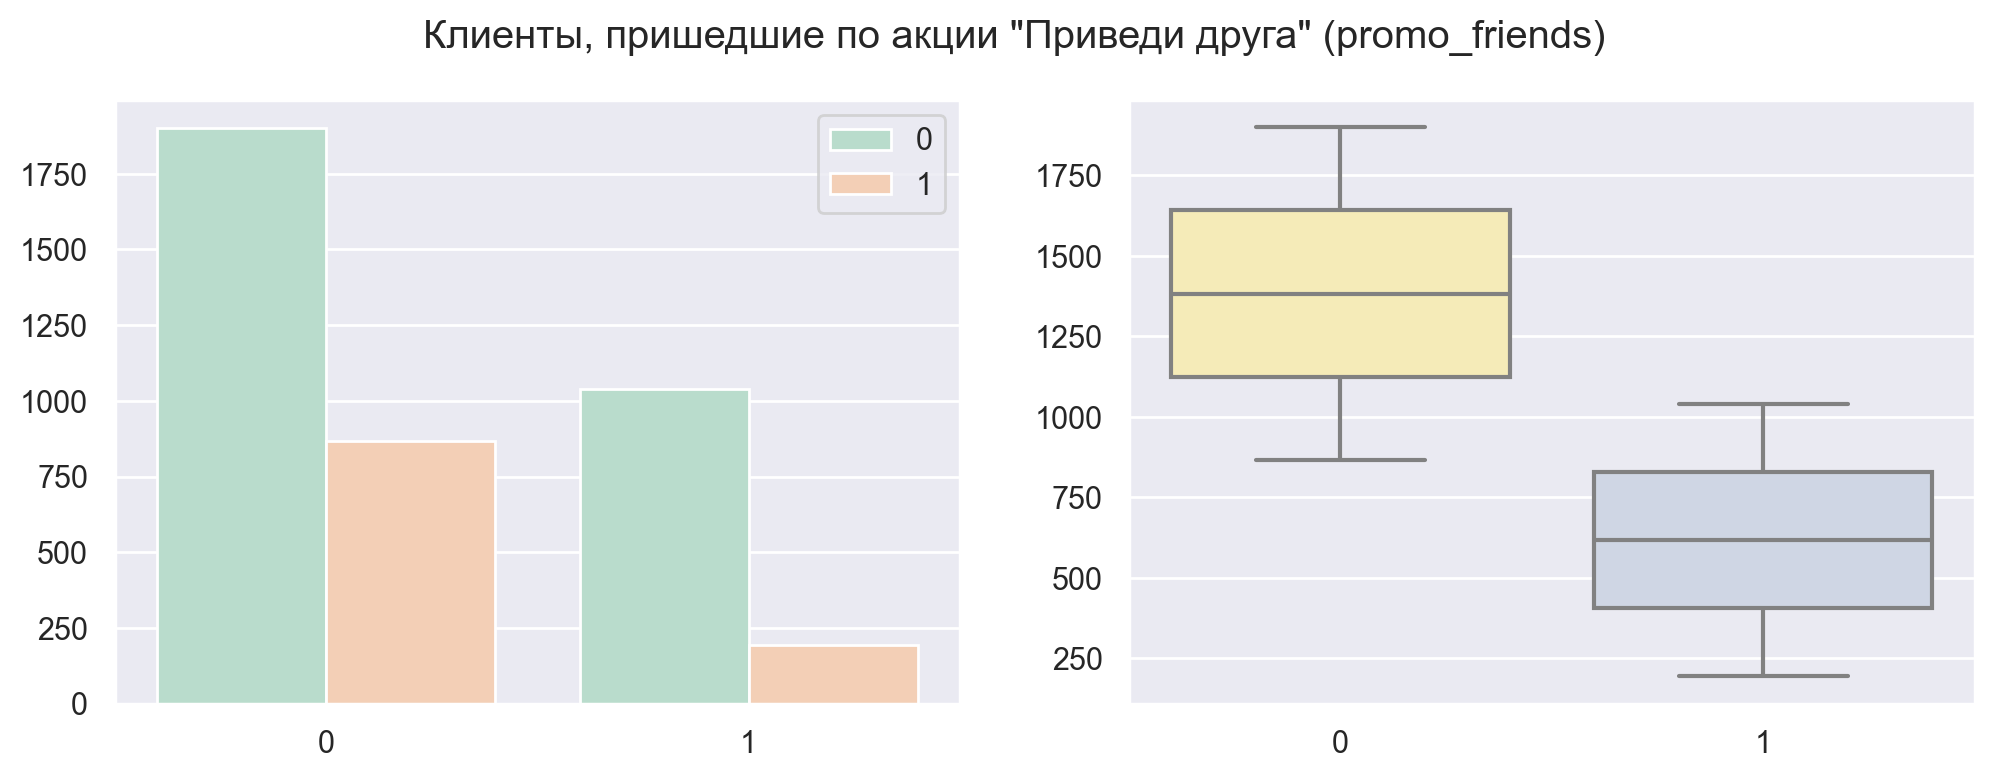

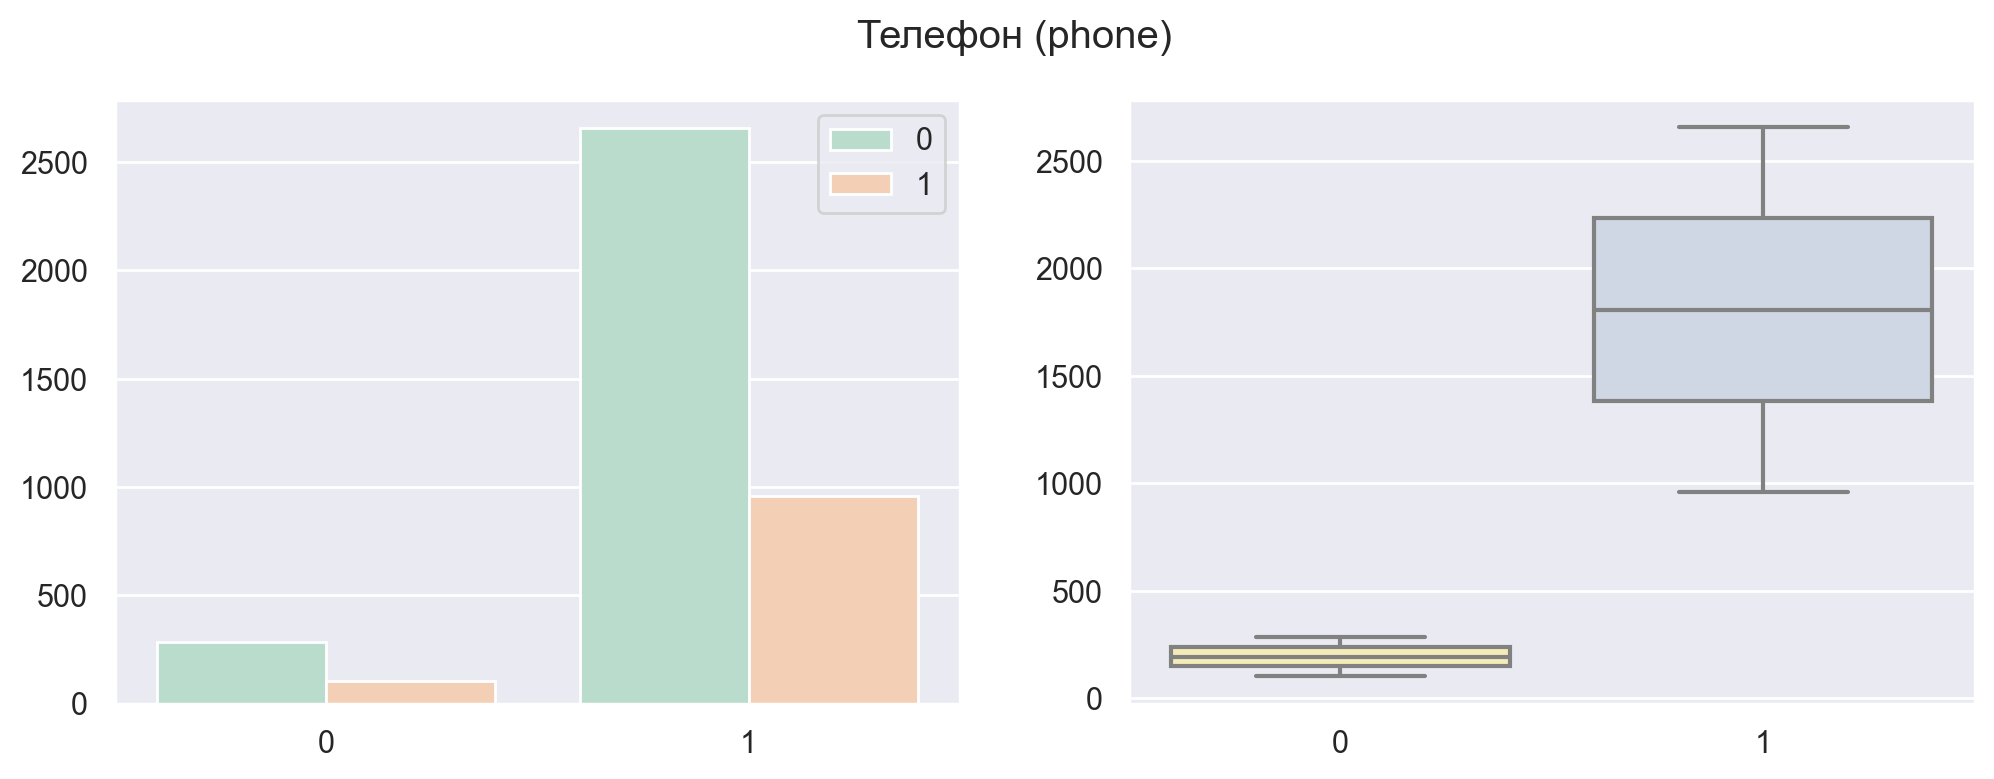

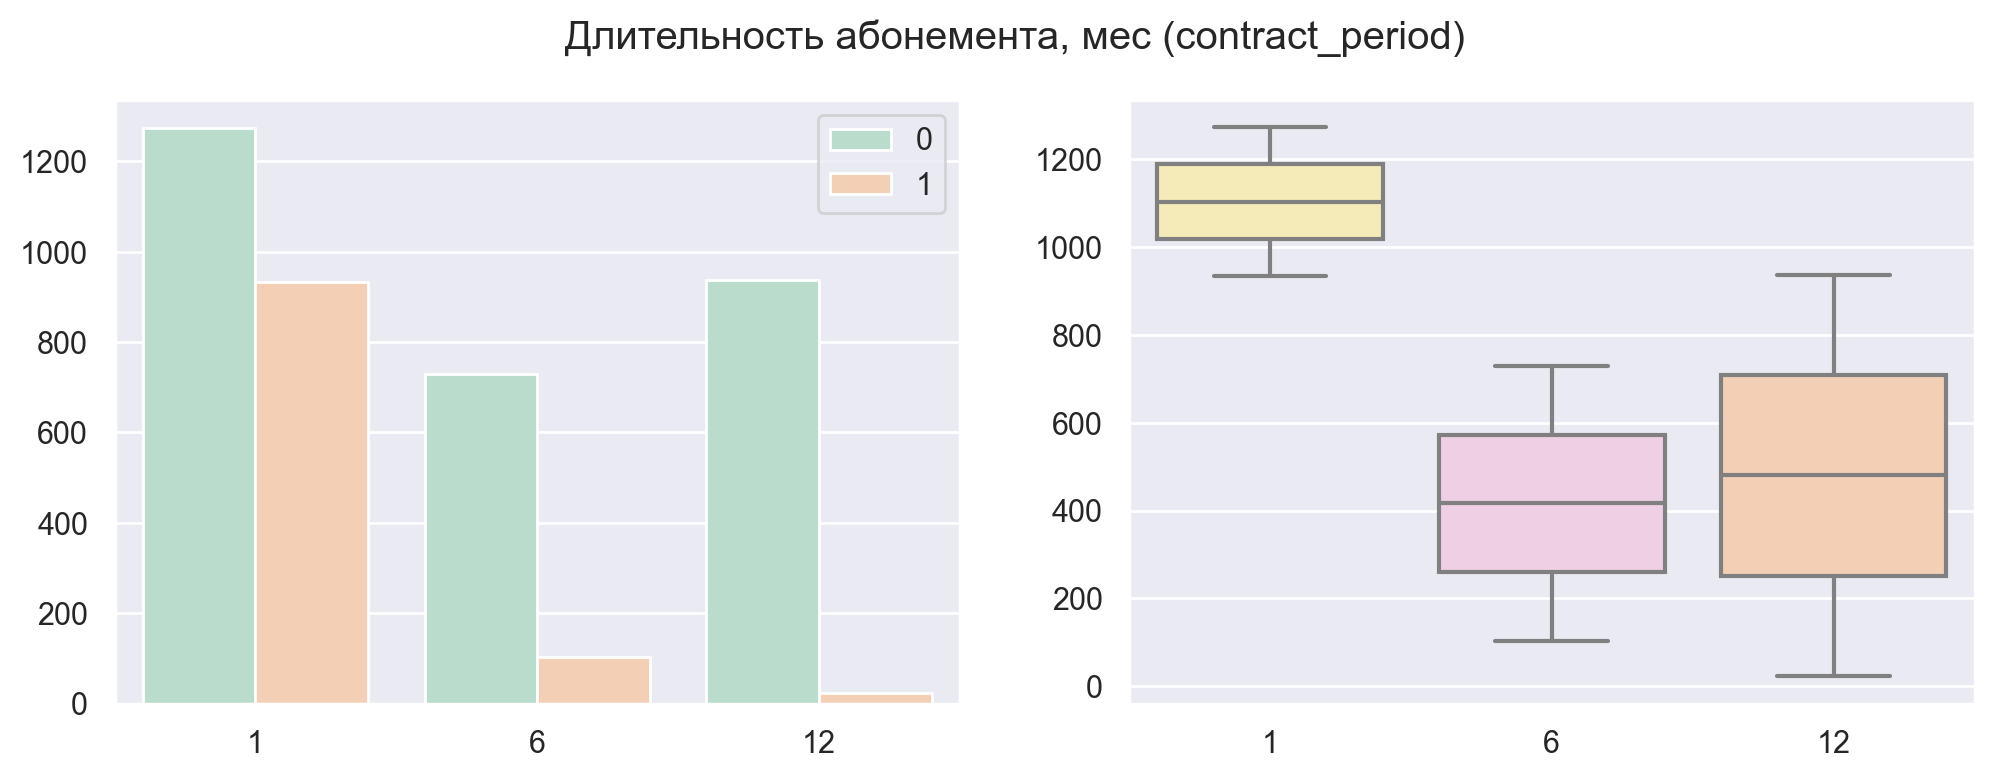

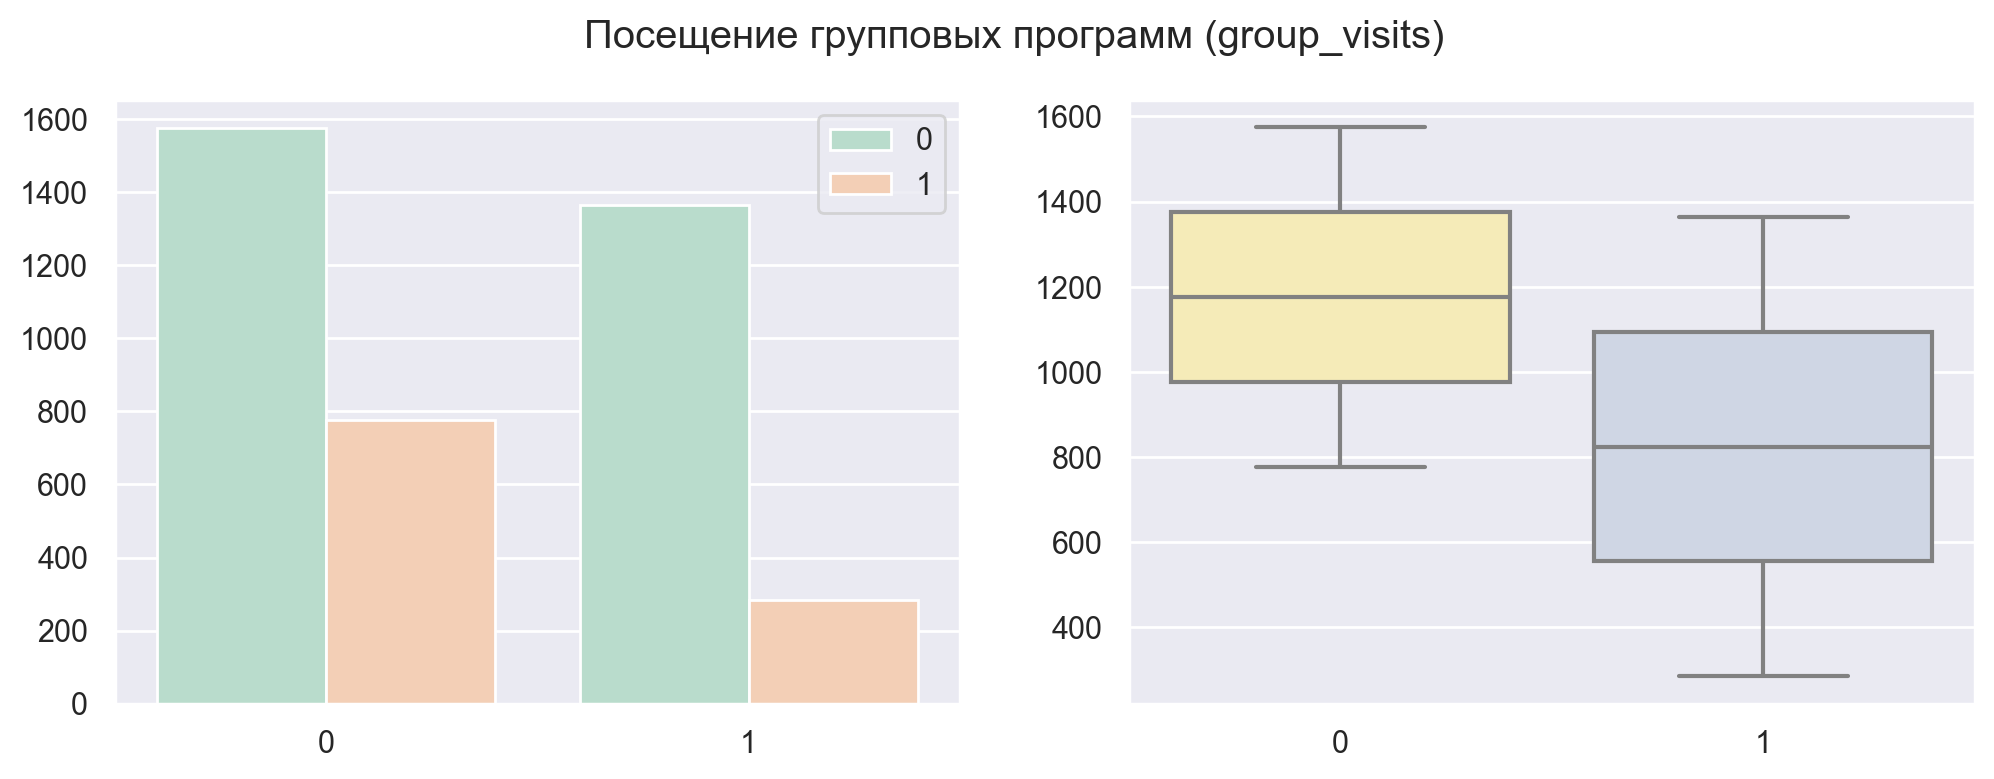

In [12]:
for index, row in categorical.iterrows():
    categorical_plots(data, row[0], row[1])

**Выводы**

На отток **не влияют** пол и наличие номера телефона в анкете.

На отток, определенно, **оказывают влияние**:
1. удаленность фитнес-центра от меcта проживания или работы;
2. отcутствие скидки от компании-партнера или по акции "Приведи друга";
3. наличие абонемента сроком на месяц (а не на более длинный срок);
4. индивидуальные визиты, а не посещение групповых занятий.


### Матрица корреляции

Построим матрицу корреляций признаков.

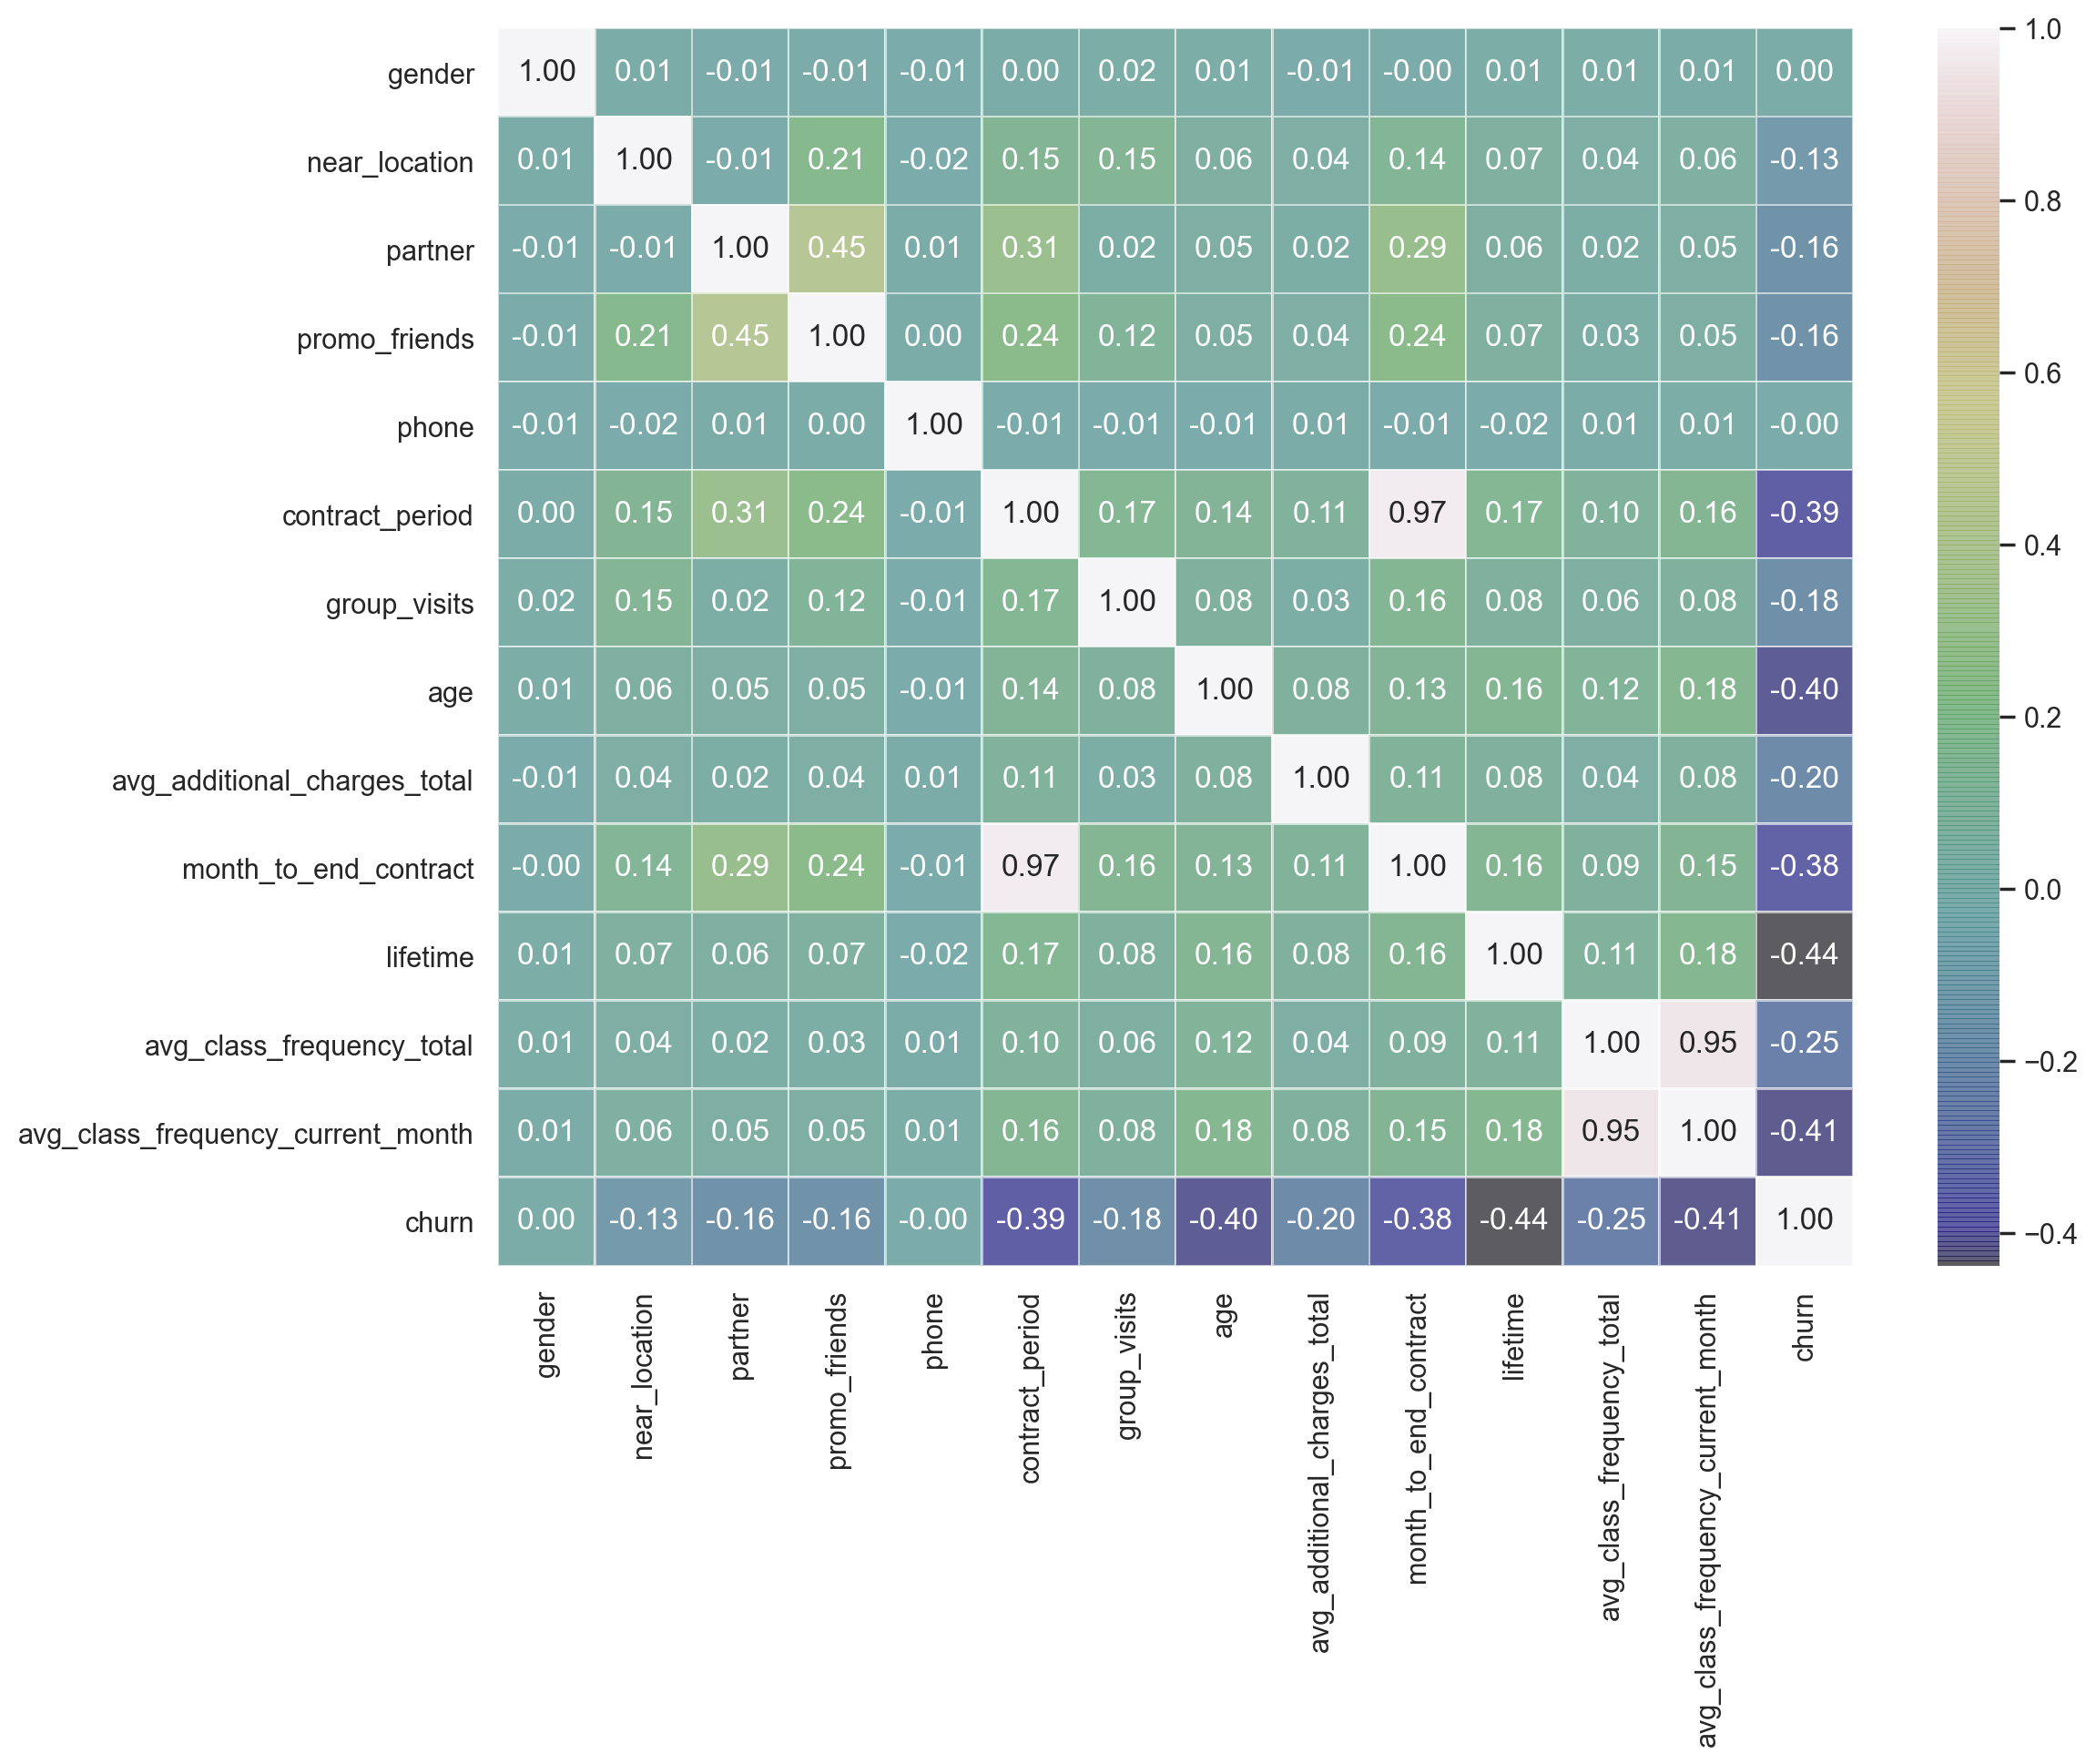

In [13]:
f, ax = plt.subplots(figsize=(12, 9))

sns.heatmap(data.corr(), annot=True, linewidths=.5, ax=ax, cmap='gist_earth',fmt = '0.2f', alpha=.6)
plt.show()

**Выводы**

Сильно влияющих на отток признаков на тепловой карте не наблюдается.  
    
Больше остальных с целевой переменной коррелирует продолжительнось посещения (lifetime)  - чем он больше, тем меньше вероятность оттока.   

Далее по значимости следуют: средняя частоста посещений клуба за последний месяц, возраст, срок действующего абонемента и количество месяцев до истечения абонемента.

Пол (gender) и наличие телефона в анкете (phone) никак не связаны с оттоком.

Между собой сильно коррелируют две пары признаков:
* срок абонемента (contract_period) и количество месяцев до конца абонемента (month_to_end_contract)
* средняя частота посещений за весь период (avg_class_frequency_total) и средняя частота посещений за последний месяц (avg_class_frequency_current_month)

Вероятно, из-за того, что большинство абонементов покупаются на 1 месяц.


## Модель прогнозирования оттока клиентов  

Для начала подготовим наши данные: уберем выбросы по всем числовым признакам (они были хорошо видны на диаграммах размаха) по 99му процентилю.

In [14]:
print('Количество строк до удаления выбросов:', len(data))

for col in numeric['col']:
    data = data[data[col] <= np.percentile(data[col], 99)]

print('Количество строк после удаления выбросов:', len(data))

Количество строк до удаления выбросов: 4000
Количество строк после удаления выбросов: 3831


Так же, удалим колонки `phone` и `gender`, т.к. они никак не влияют на отток посетителей.

In [15]:
data = data.drop(['phone', 'gender'], axis=1)

Построим модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце.
Разобьем данные на обучающую и валидационную выборки функцией `train_test_split()`.   

Обучим модель на train-выборке двумя способами:

* логистической регрессией,
* случайным лесом.   

Оценим метрики `accuracy`, `precision`, `recall` и `F1-score` для обеих моделей на валидационной выборке. Сравним модели и увидим, какая модель показала себя лучше на основании метрик.

In [16]:
# функция для вывода метрик;
# на входе подаются валидационное значение, предсказанное и наименование метрики;

def metrics(y_test, predictions, title):
    print(title)
    print('\tAccuracy (Доля правильных ответов): {:.2f}'.format(accuracy_score(y_test, predictions)))
    print('\tPrecision (Точность): {:.2f}'.format(precision_score(y_test, predictions)))
    print('\tRecall (Полнота): {:.2f}'.format(recall_score(y_test, predictions)))
    print('\tF1-score (сводная метрика): {:.2f}'.format(f1_score(y_test, predictions)))

In [17]:
# разделим наши данные на признаки (матрица X) и целевую переменную (y)
X = data.drop('churn', axis=1)
y = data['churn']

# разделяем модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0
)

### Логистическая регрессия

In [18]:
# зададим алгоритм для нашей модели
lr_model = LogisticRegression(solver='liblinear')

# обучим модель
lr_model.fit(X_train, y_train)

# воспользуемся уже обученной моделью, чтобы сделать прогнозы:
lr_predictions = lr_model.predict(X_test)

### Случайный лес

In [19]:
# обучаем StandartScaler на обучающей выборке:
scaler = StandardScaler()
scaler.fit(X_train)

# преобразуем обучающий и валидационные наборы данных:
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

# зададим алгоритм для модели на основе алгоритма случайного леса:
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0)

# обучим модель случайного леса:
rf_model.fit(X_train_st, y_train)

# воспользуемся обученной моделью, чтобы сделать прогнозы:
rf_predictions = rf_model.predict(X_test_st)

### Результаты

In [20]:
# выводми метрики:

metrics(y_test, lr_predictions, 'Метрики для алгоритма логистической регрессии:')
metrics(y_test, rf_predictions, title = 'Метрики для модели случайного леса:')

Метрики для алгоритма логистической регрессии:
	Accuracy (Доля правильных ответов): 0.92
	Precision (Точность): 0.86
	Recall (Полнота): 0.86
	F1-score (сводная метрика): 0.86
Метрики для модели случайного леса:
	Accuracy (Доля правильных ответов): 0.92
	Precision (Точность): 0.85
	Recall (Полнота): 0.85
	F1-score (сводная метрика): 0.85


Мы видим, что показатели метрик практически не отличаются, но **модель логистической регрессии** в нашем случае показала чуть лучшие результаты.

После подгонки модели коэффициенты сохраняются в свойстве `coef_`.

Следующий фрагмент обучает модель логистической регрессии, создает фрейм данных, в котором хранятся признаки с соответствующими коэффициентами, и сортирует этот фрейм данных по коэффициенту в порядке убывания.

In [21]:
# зададим алгоритм для нашей модели
flr_model = LogisticRegression(solver='liblinear')

# обучим модель
flr_model.fit(X_train, y_train)

# воспользуемся уже обученной моделью, чтобы сделать прогнозы:
importances = pd.DataFrame(data={
    'attribute': X_train.columns,
    'importance': flr_model.coef_[0]
})
importances = importances.sort_values(by='importance', ascending=False)
importances

,attribute,importance
9,avg_class_frequency_total,3.32
0,near_location,0.08
1,partner,0.06
6,avg_additional_charges_total,-0.00
7,month_to_end_contract,-0.03
5,age,-0.18
3,contract_period,-0.25
2,promo_friends,-0.59
4,group_visits,-0.72
8,lifetime,-0.96


## Кластеризация клиентов

Проведем класторизацию клиентов. Построим матрицу расстояний функцией `linkage()` на стандартизованной матрице признаков и нарисуем дендрограмму. 

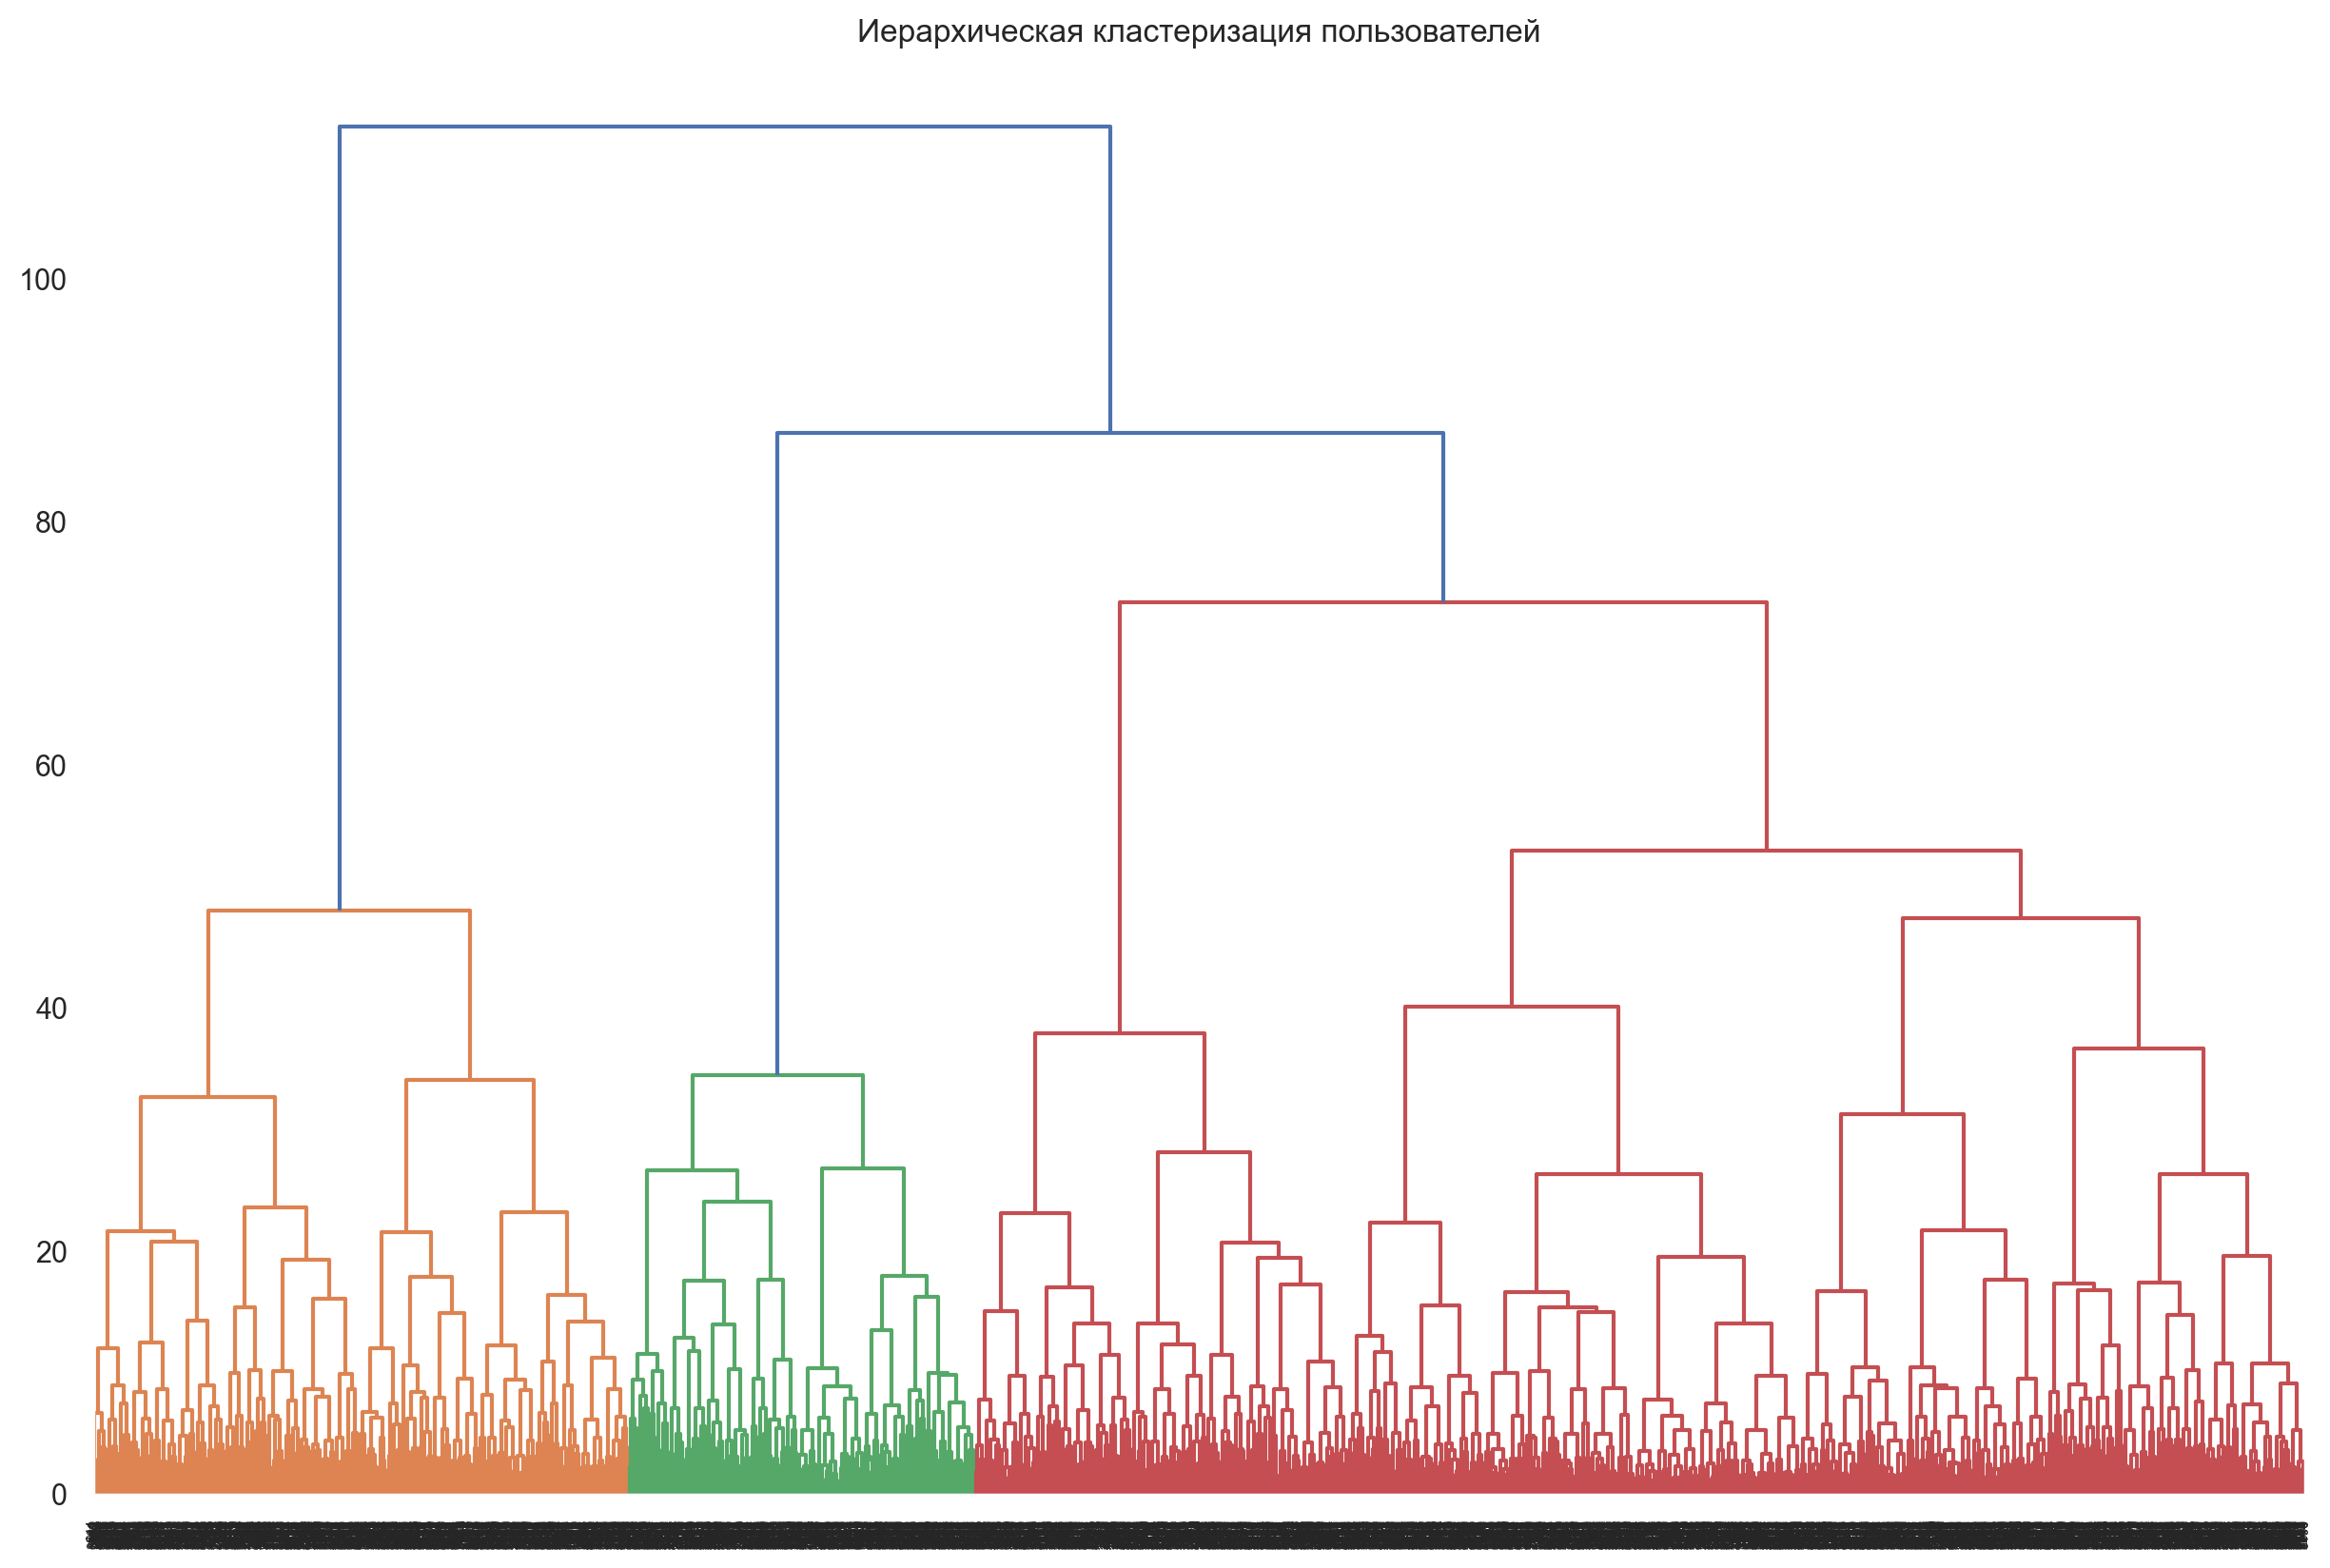

In [22]:
# выделим данные для кластеризации:
x = data.drop('churn', axis = 1)

# обязательная стандартизация данных перед работой с алгоритмами
sc = StandardScaler()
x_sc = sc.fit_transform(x)

# строим таблицу расстояний между объектами:
linked = linkage(x_sc, method = 'ward')

# визуализируем (строим дендрограмму):
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Иерархическая кластеризация пользователей')
plt.show()


На дендрограмме мы видим три цвета, красная область получилась явно больше остальных, попробуем разбить данные на 5 кластеров для большей детализации.

Обучим модель кластеризации на основании алгоритма K-Means.

In [23]:
# задаём модель k_means с числом кластеров 5 и фиксируем значение random_state
km = KMeans(n_clusters=5, random_state=0) 

# применяем алгоритм к данным и формируем вектор кластеров (алгоритм присваивает им номера от 0 до 4)
labels = km.fit_predict(x_sc)

# сохраняем метки кластера в поле нашего датасета
data['cluster_km'] = labels

# выводим статистику по средним значениям наших признаков по кластеру
display(data.groupby('cluster_km').mean().T)

# выведем размеры кластеров
print('Размеры кластеров:')
display(data.cluster_km.value_counts())

# посчитаем метрику силуэта для нашей кластеризации:
print('Silhouette_score (метрика силуэта): {:.2f}'.format(silhouette_score(x_sc, labels)))


cluster_km,0,1,2,3,4
near_location,1.00,0.98,0.94,0.00,1.00
partner,0.84,0.23,0.74,0.47,0.25
promo_friends,1.00,0.06,0.49,0.08,0.03
contract_period,3.16,2.64,11.87,2.17,1.94
group_visits,0.45,0.46,0.55,0.21,0.32
age,29.21,30.02,29.88,28.45,28.10
avg_additional_charges_total,141.23,155.40,160.59,129.77,127.42
month_to_end_contract,2.92,2.44,10.88,2.04,1.87
lifetime,3.50,4.83,4.52,2.60,2.18
avg_class_frequency_total,1.77,2.63,1.98,1.65,1.21


Размеры кластеров:


4    1008
2     900
1     764
0     629
3     530
Name: cluster_km, dtype: int64

Silhouette_score (метрика силуэта): 0.15


*Значение метрики силуэта оказалось не очень высоким. К сожалению, в наблюдениях редко можно встретить четкое разделение по признакам на группы, поэтому результат оценки желательно дополнительно обсудить с экспертами.*

Самый надёжный кластер **№2** (2% оттока) имеет сравнительно высокие средние значения по всем признакам, но особенно выделяется продолжительным абонементом (в среднем 11.87 мес.) и количеством месяцев до его окончания (10.88). При этом следует отметить, что жизненный цикл у таких клиентов так же высок. Можно предположить, что данные клиенты сначала покупали месячные абонементы, а потом - абонементы на 6 и 12 месяцев.

Второй по надёжности кластер **№1** (9% оттока) выделяется более высоким средним возрастом клиентов (30 лет) и частотой посещения клуба (как за весь период, так и за последний месяц, т.е. налицо характерная интенсивность посещений и вовлеченность).

Самый высокий отток (57%)у кластера **№4**. Клиенты данной группы живут или работают поблизости, но по всем остальным признакам значения ниже, чем у остальных кластеров (возраст, траты, посещение, жизненный цикл + отсутствие скидок).   

Еще один кластер, вызывающий тревожность - это **№3** с 46% оттока. Очень похож на кластер №4, но состоит из клиентов, живущих или работающих в отделении от фитнес-клуба.

### Распределения признаков в разрезе кластеров

Построим распределения признаков для кластеров. Возможно, мы увидим что-то еще и скорректируем промежуточные выводы

In [24]:
# функция по отрисовке гистограммы распределения и диаграммы размаха для числовых признаков;
# на входе функии передем параметры: датафрейм, название столбца, по которому строим график, название графика;

def cluster_numeric_plots(df, col, title):
    fig, ax = plt.subplots(figsize = (12, 4))

    for cluster in [df.loc[df['cluster_km'] == i] for i in range(5)]:
        sns.distplot(cluster[col], label = cluster['cluster_km'].unique(),
                     hist=False, ax = plt.subplot(1, 2, 1))
        plt.xlabel('')
        plt.ylabel('')
        plt.legend()

    sns.boxplot(y = df[col], x = df['cluster_km'], ax = plt.subplot(1, 2, 2), palette='Pastel2') 
    plt.xlabel('')
    plt.ylabel('')

    fig.suptitle(title + ' (' + col + ') в разрезе кластеров')
    plt.show()

In [25]:
# функия по отрисовке столбчатых диаграмм и диаграммы размаха для категориальных признаков;
# на входе функии передем параметры: датафрейм, название столбца, по которому строим график, название графика;

def cluster_categorical_plots(df, col, title):
    fig, ax = plt.subplots(figsize = (12, 4))

    sns.countplot(x = 'cluster_km', hue = col, data = df, ax = plt.subplot(1, 2, 1),  palette='Pastel2')
    plt.ylabel('')
    plt.xlabel('')
    plt.legend() 
    
    gr = df.groupby([col, 'cluster_km']).agg(count=('age', 'count')).reset_index()
    sns.boxplot(x = 'cluster_km', y = 'count', data = gr, ax = plt.subplot(1, 2, 2), palette='Pastel2') 
    plt.xlabel('')
    plt.ylabel('')

  
    fig.suptitle(title + ' (' + col + ') в разрезе кластеров')
    plt.show()

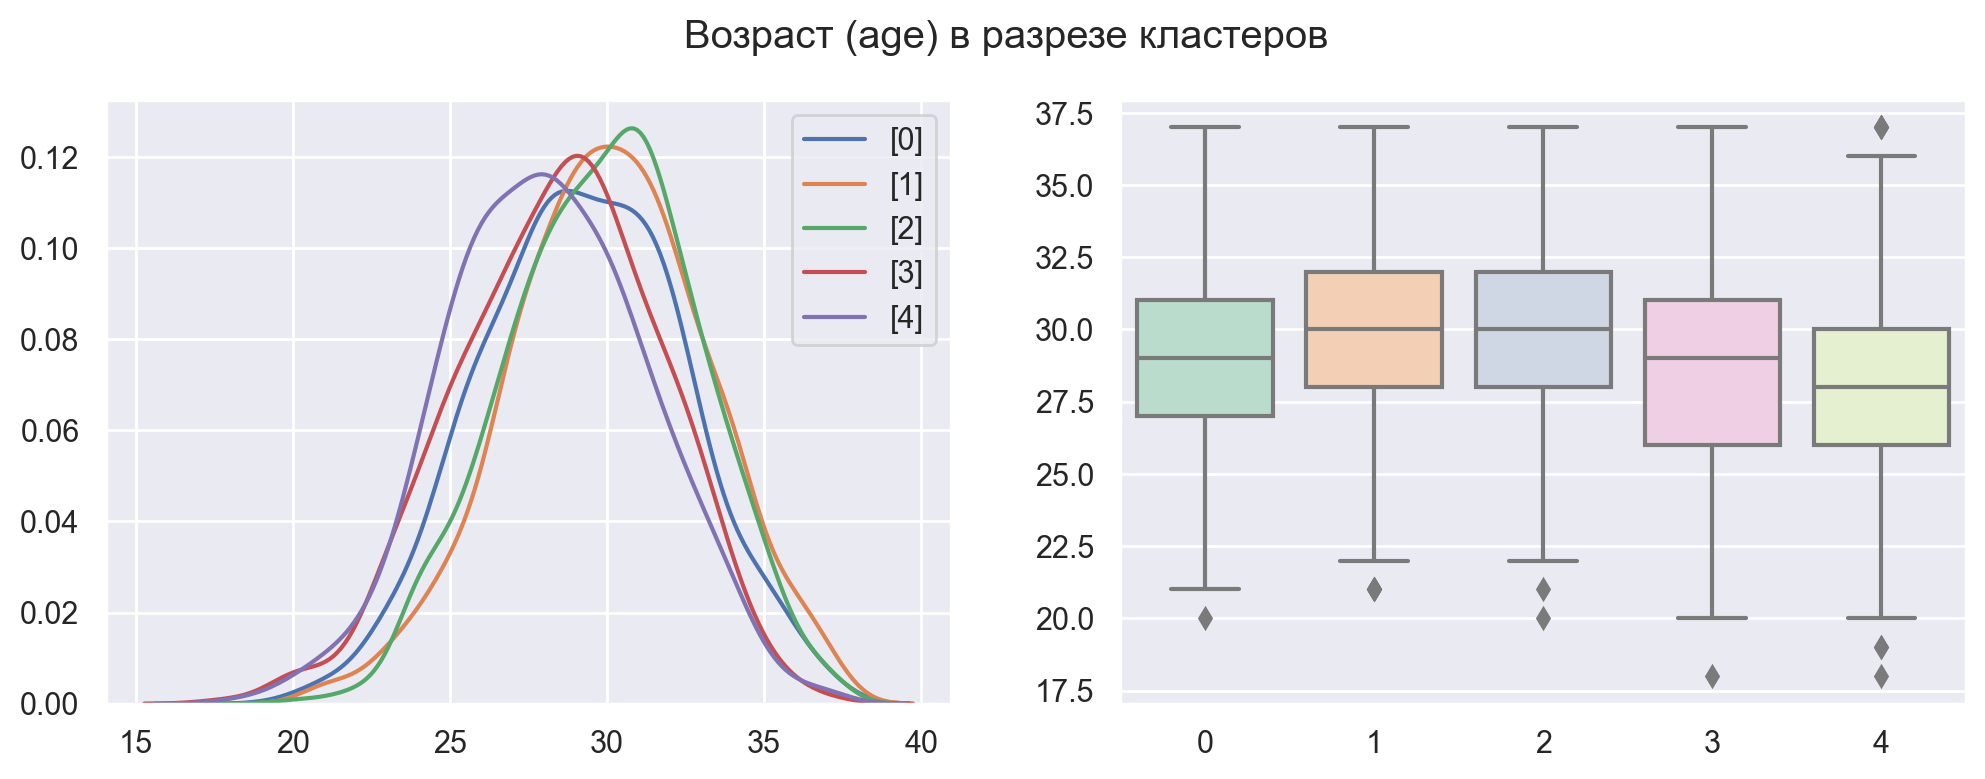

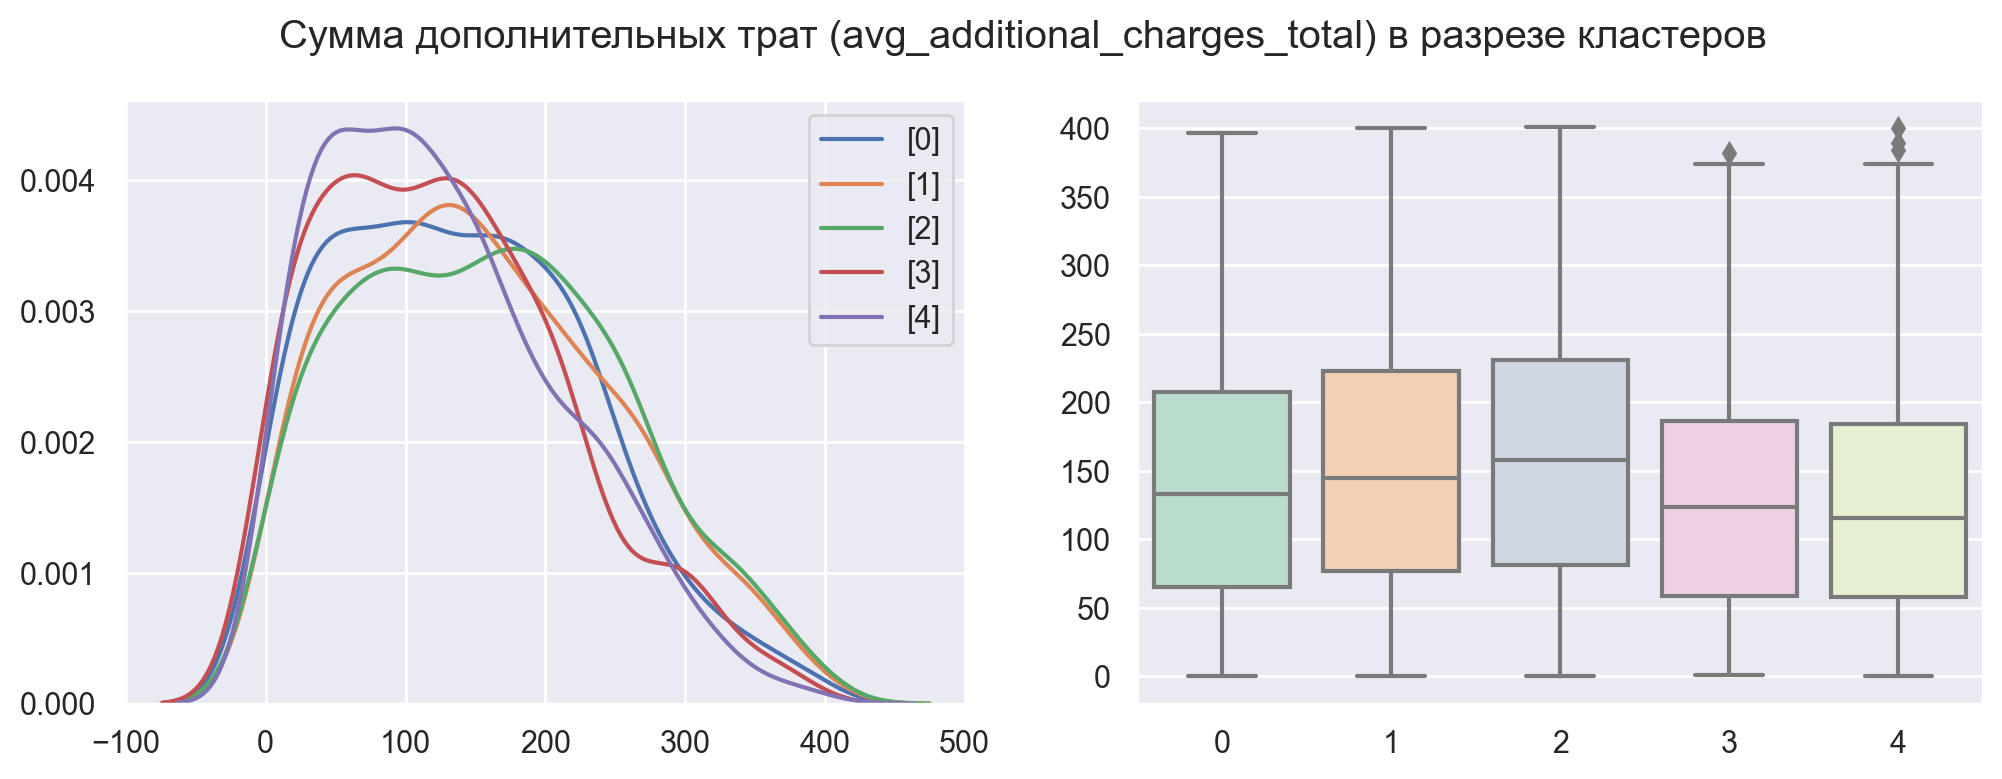

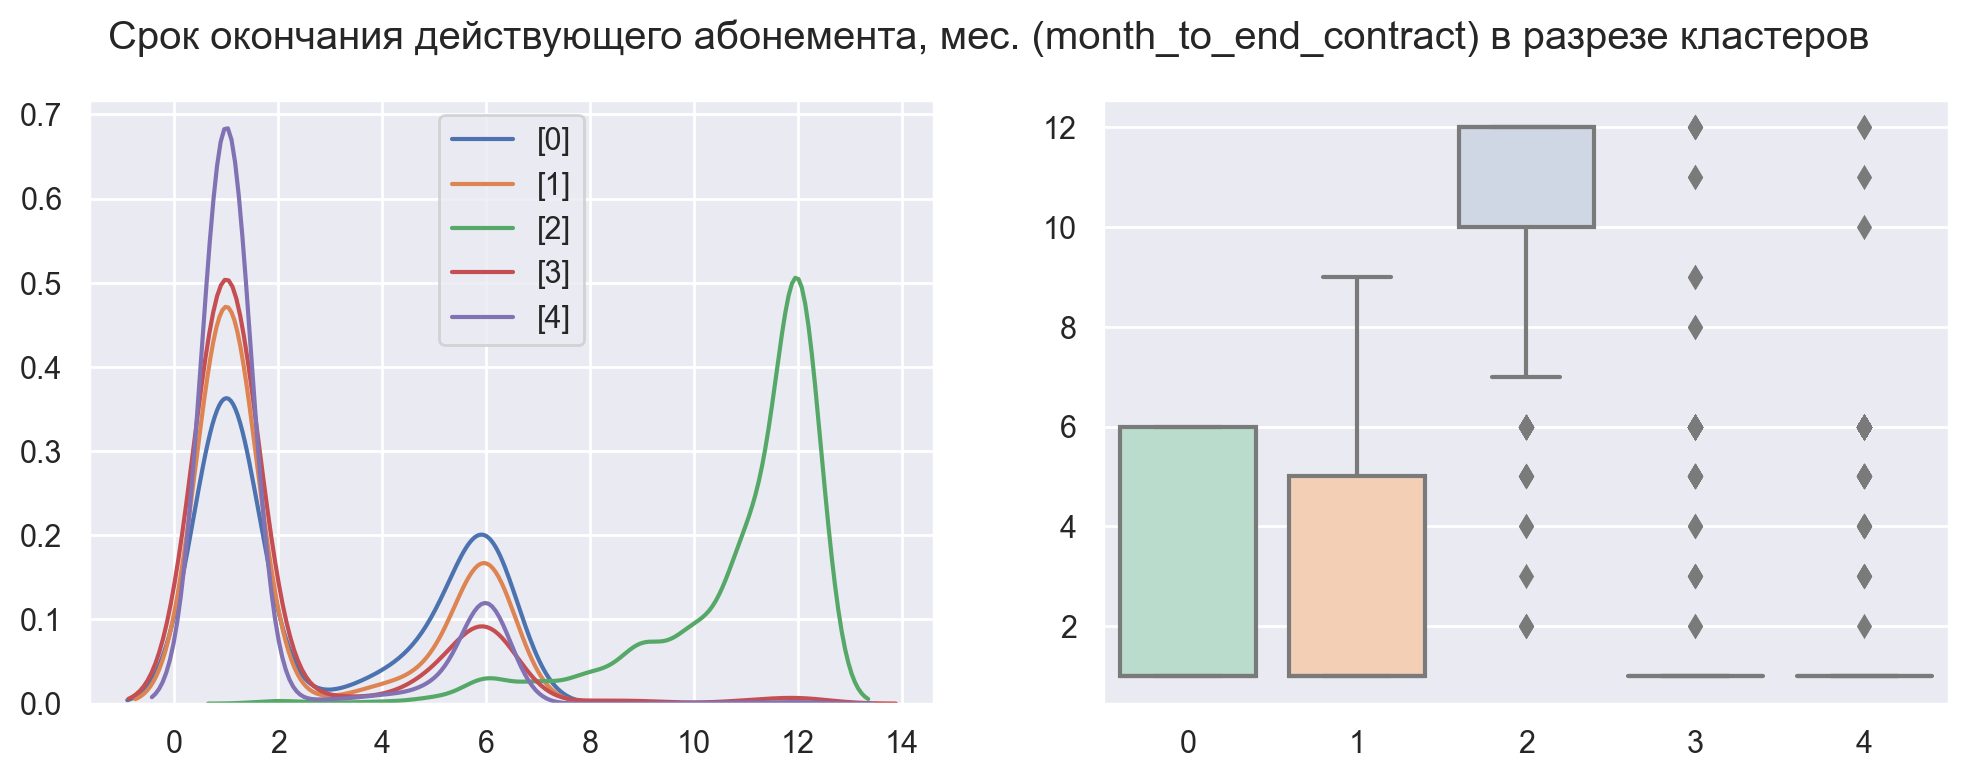

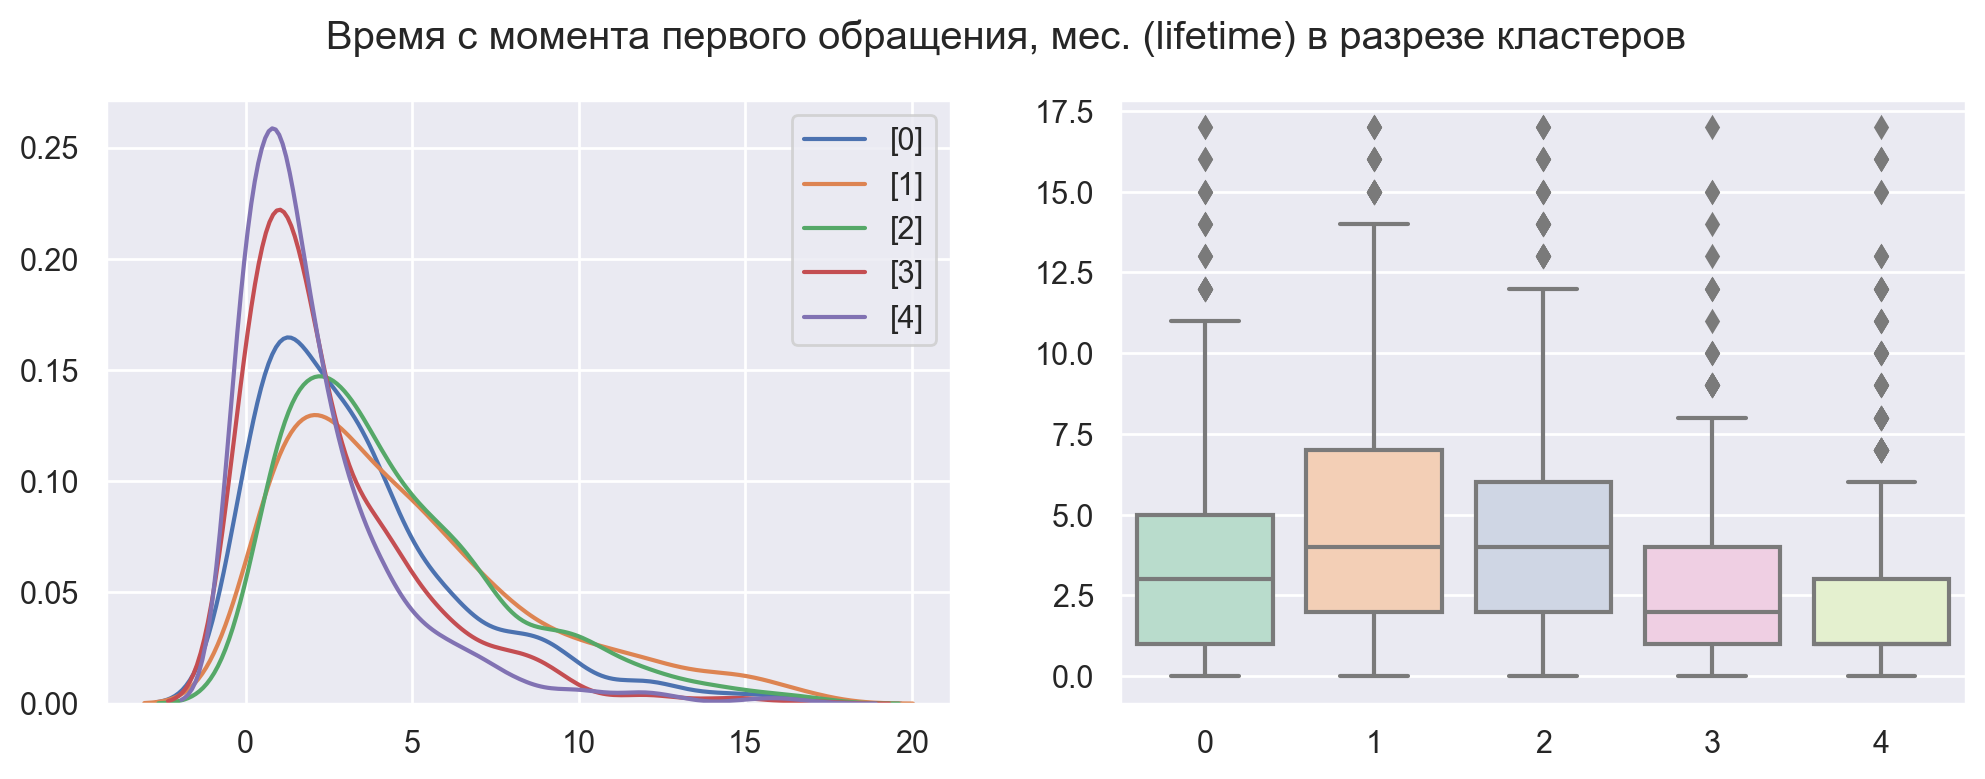

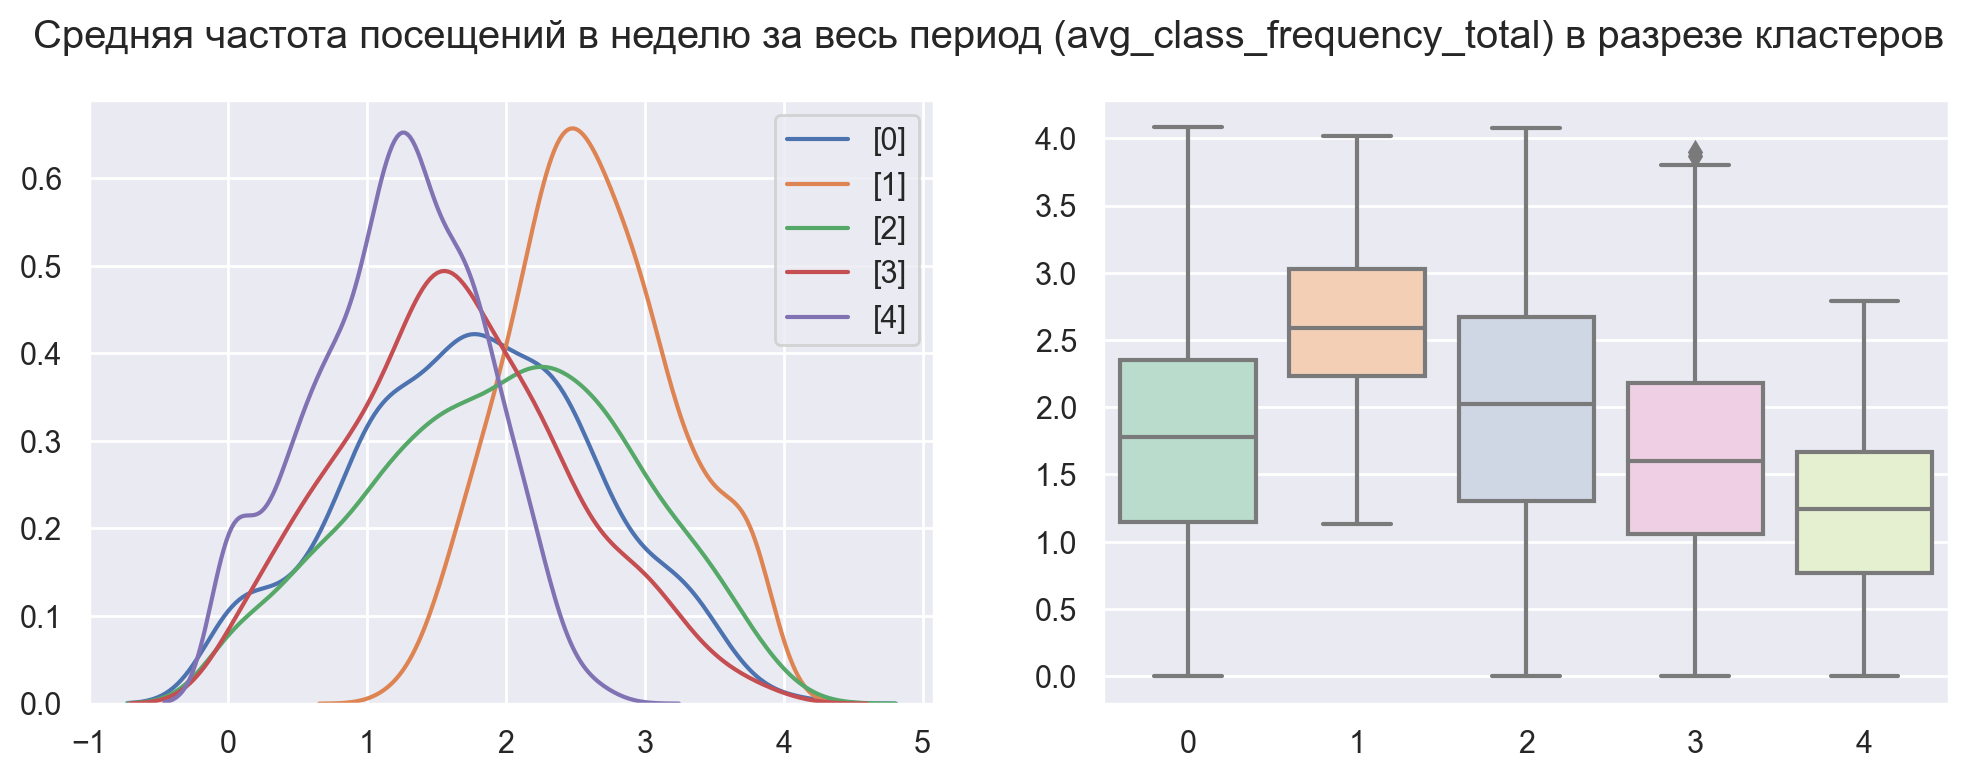

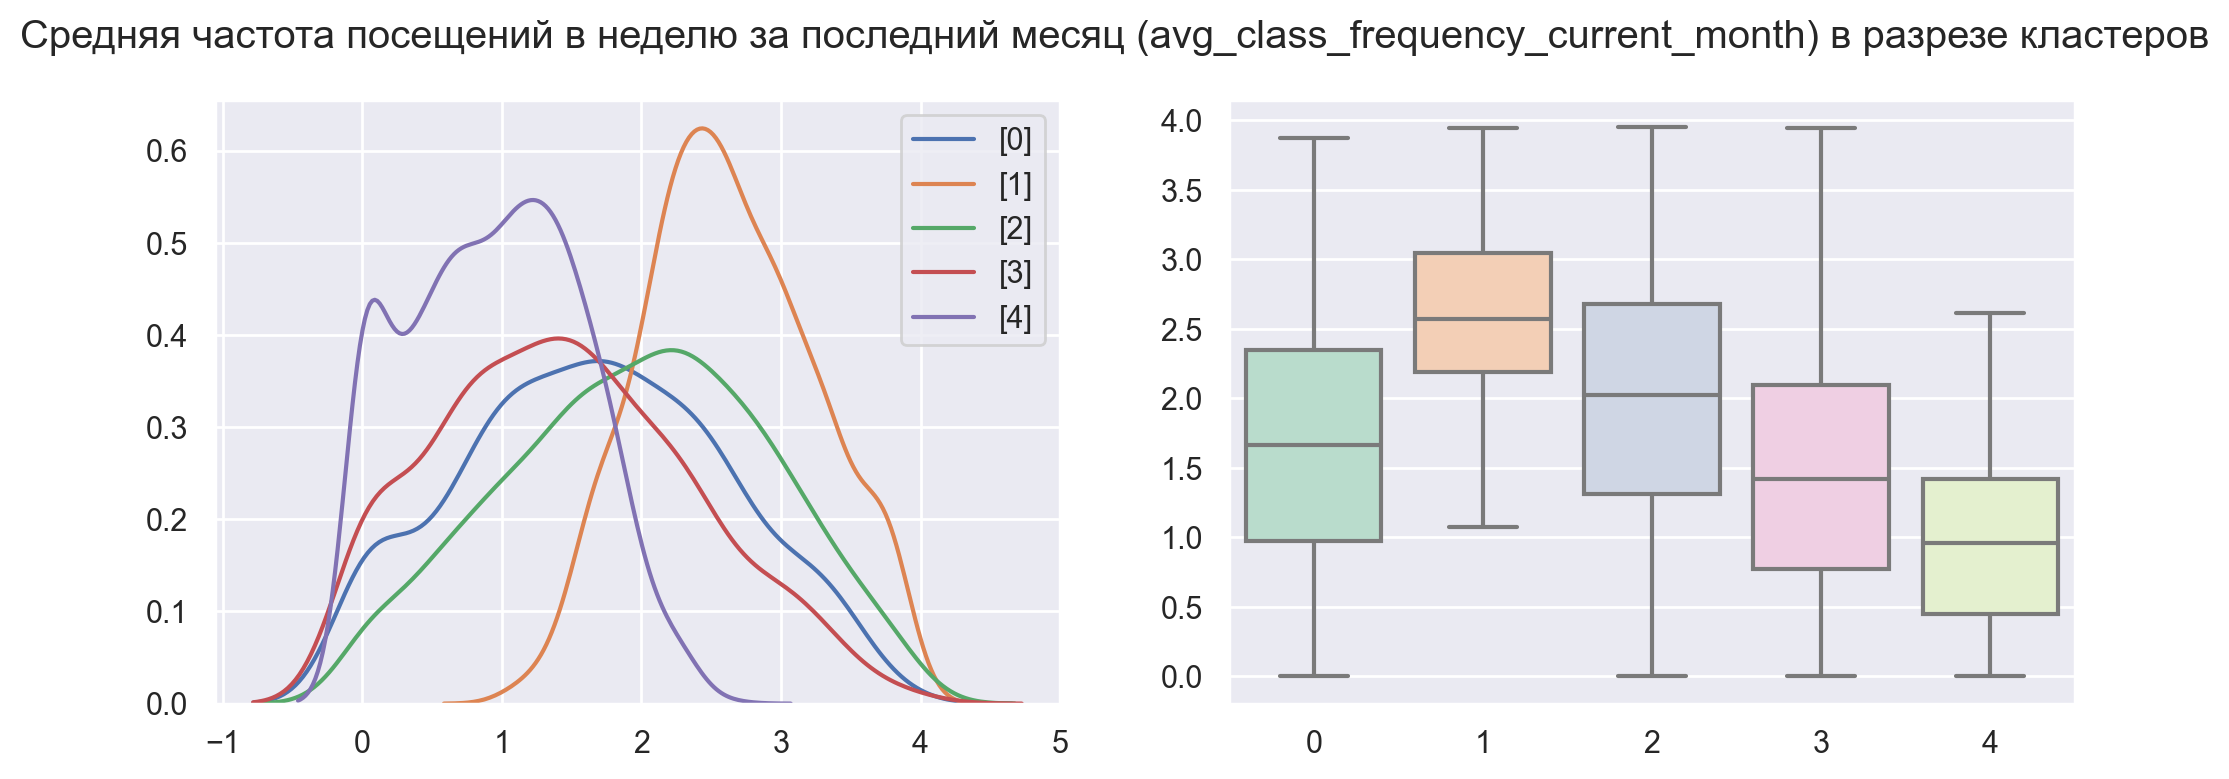

In [26]:
for index, row in numeric.iterrows():
    cluster_numeric_plots(data, row[0], row[1])

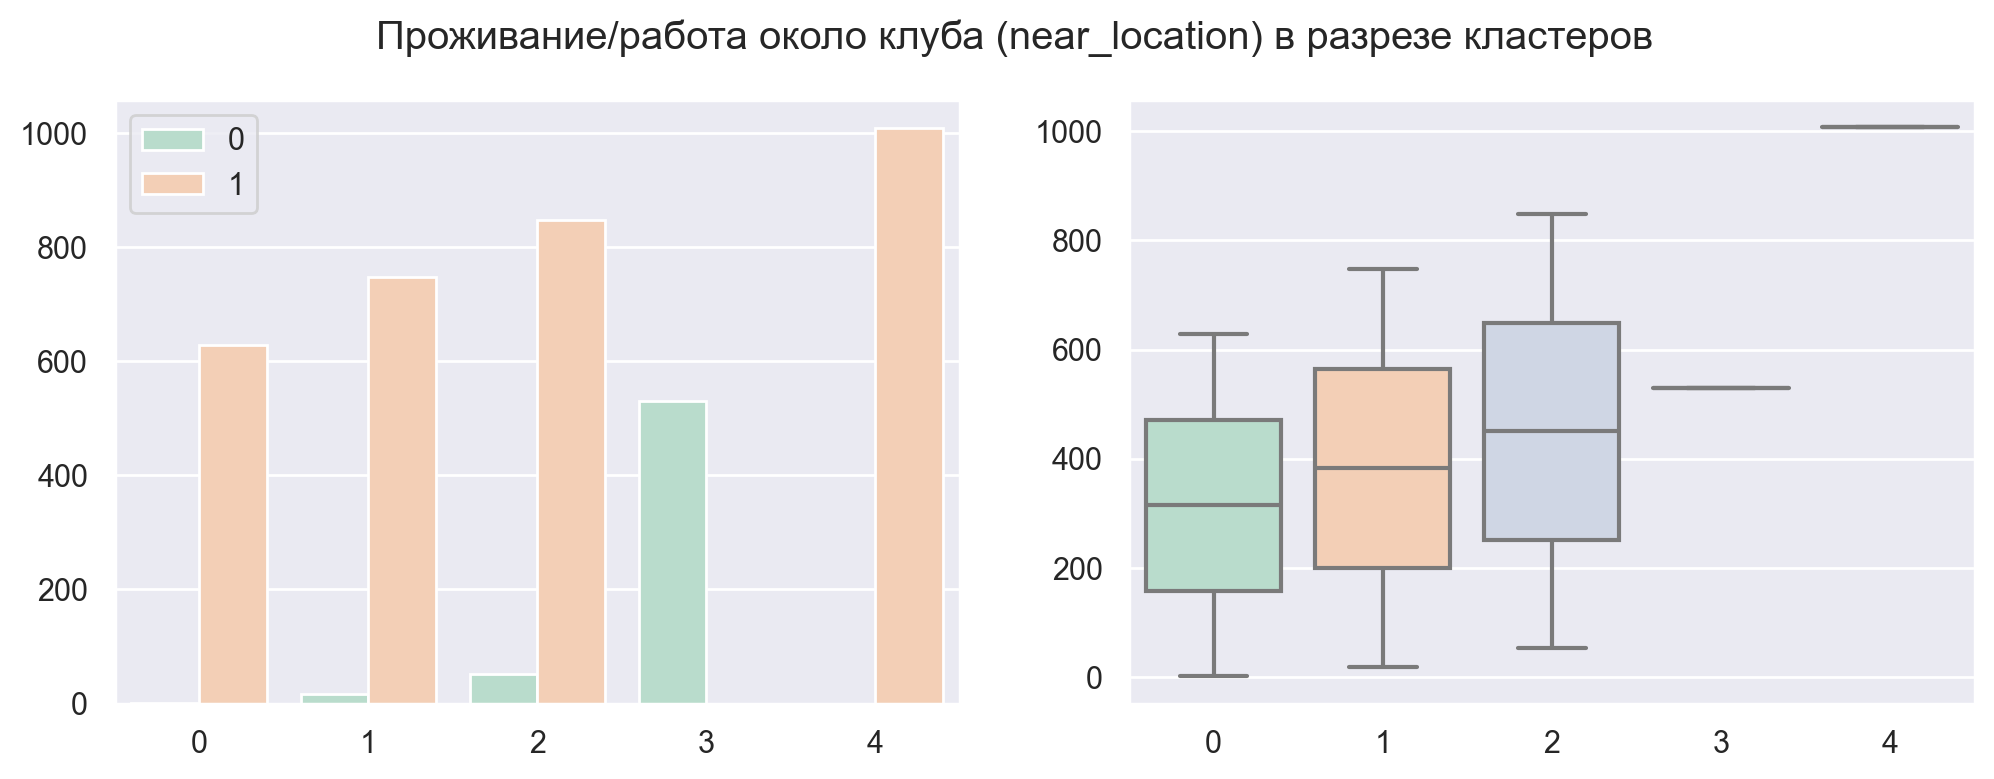

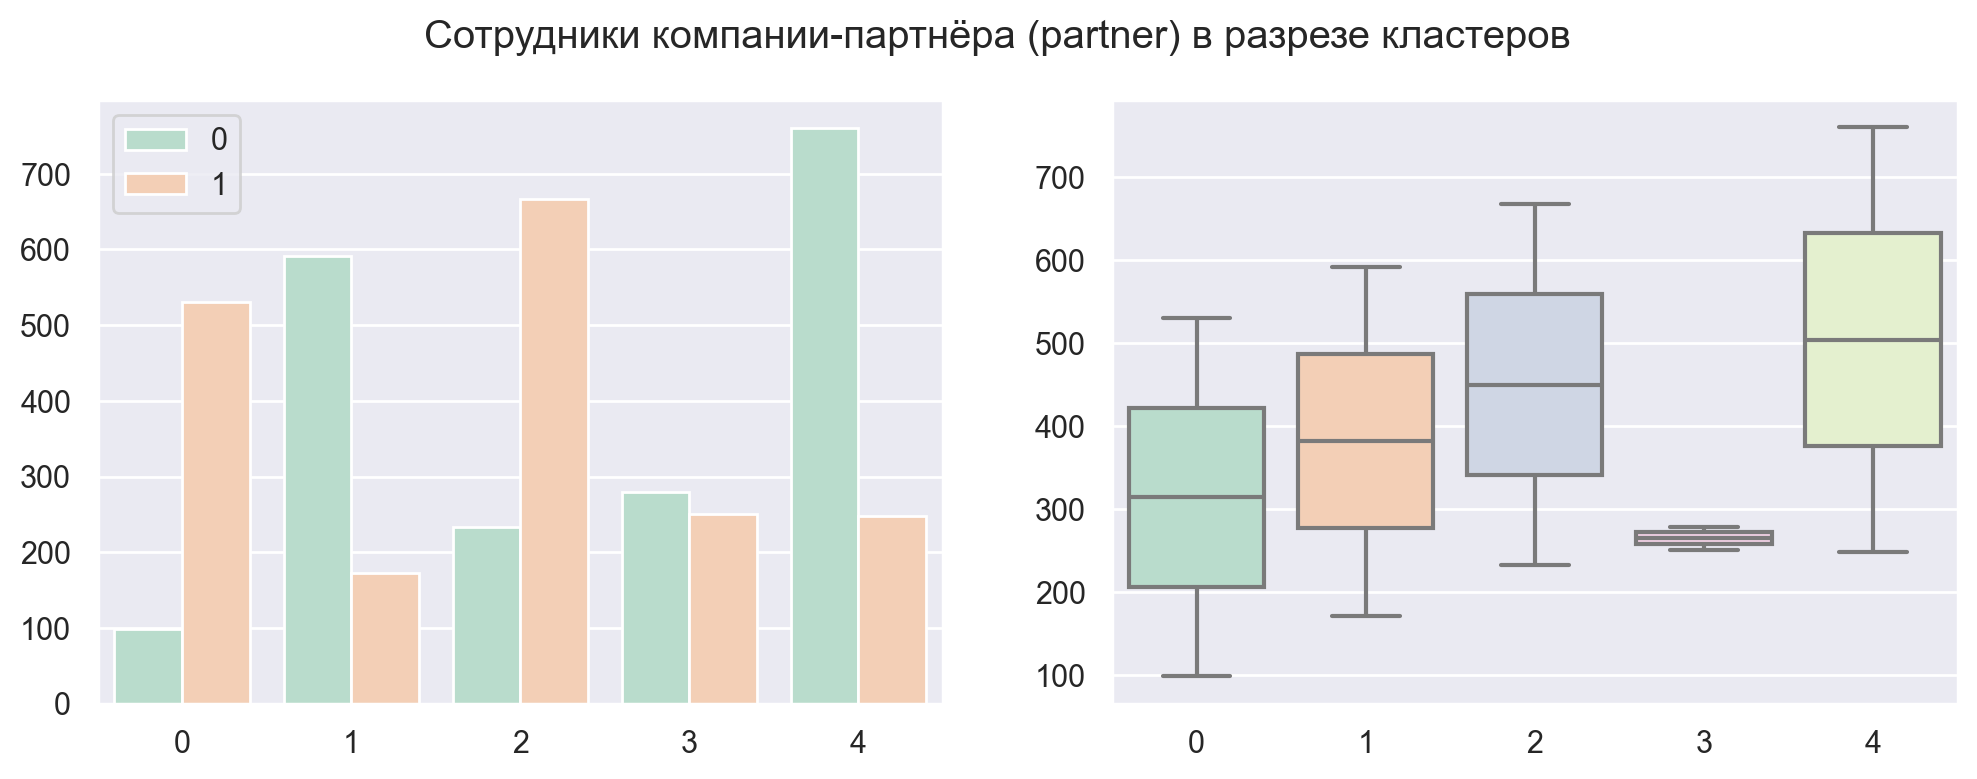

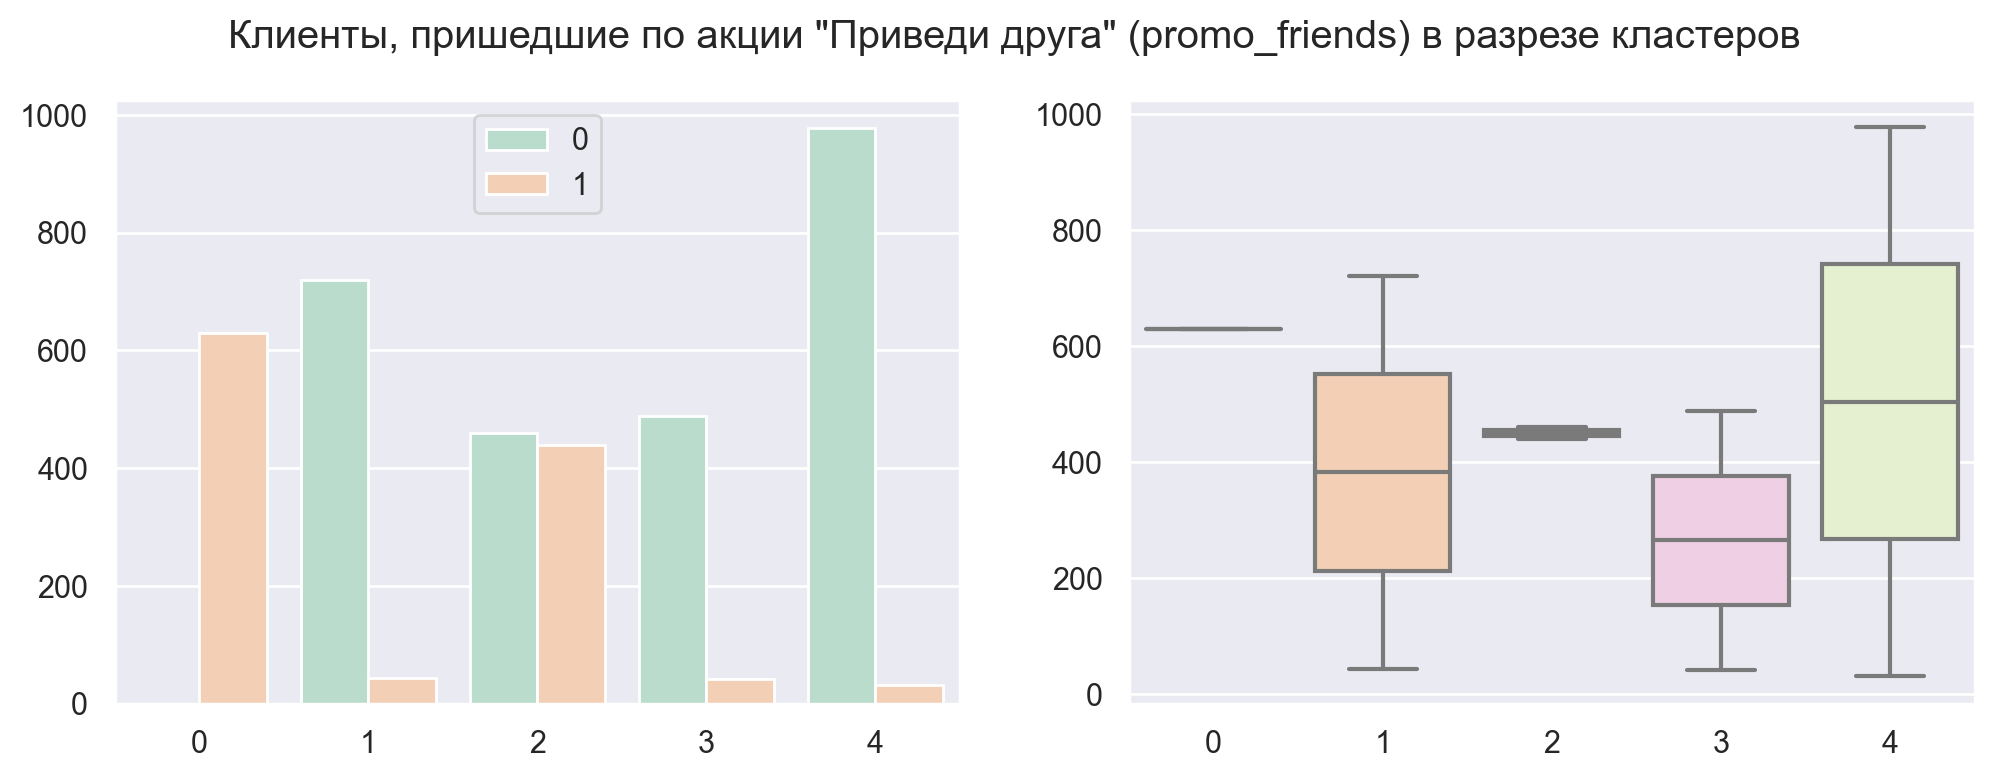

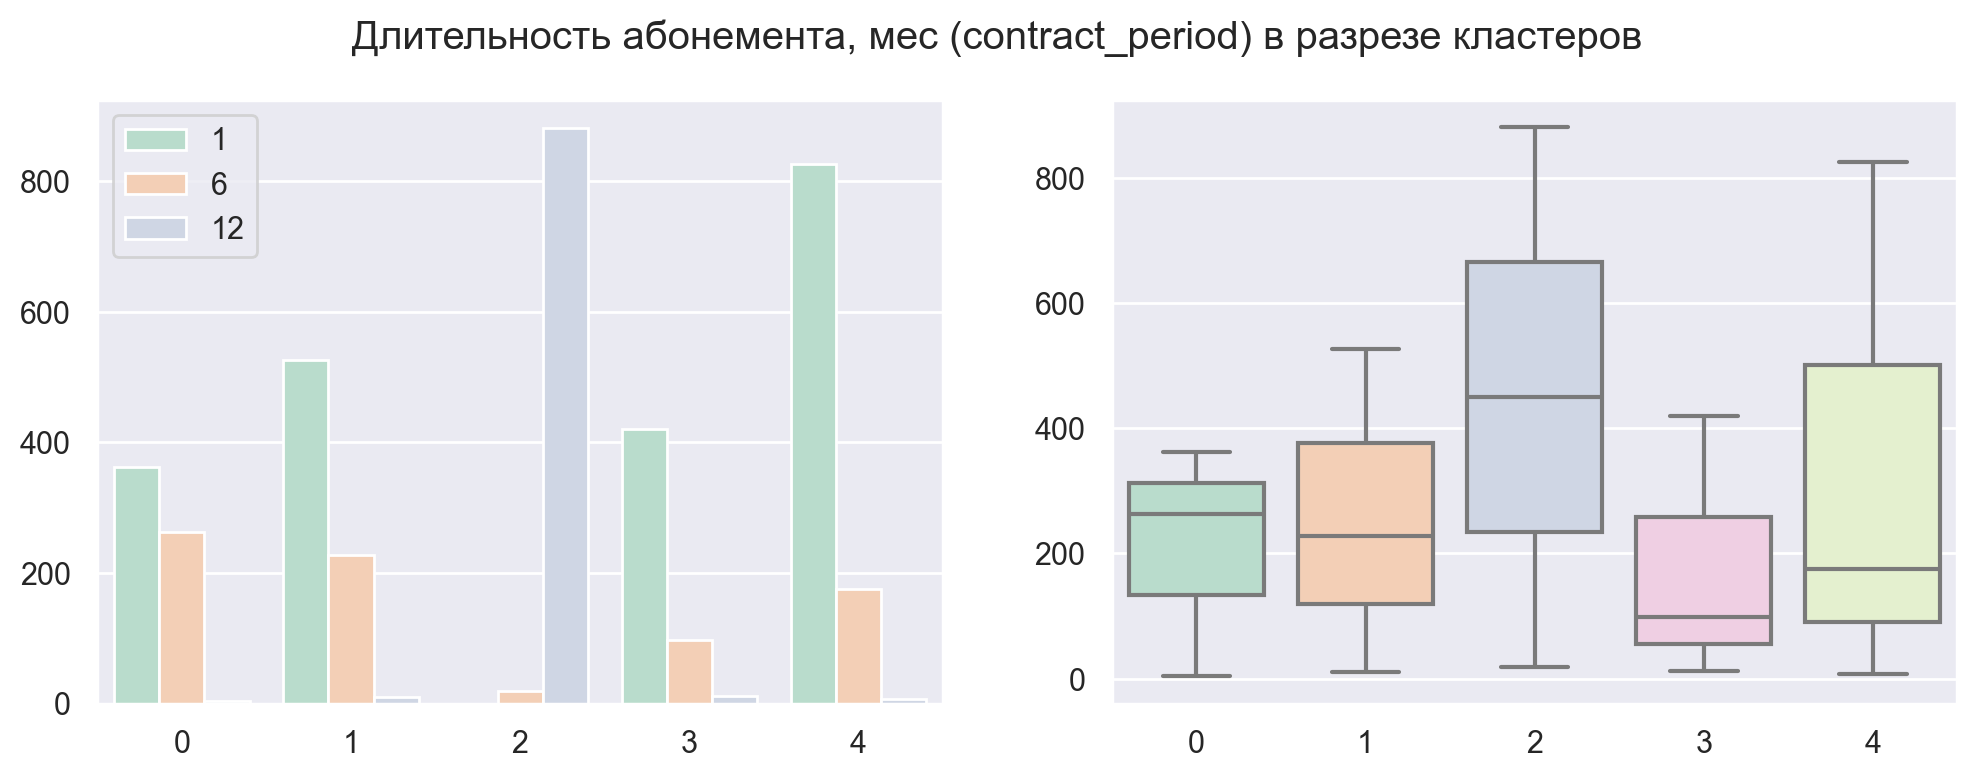

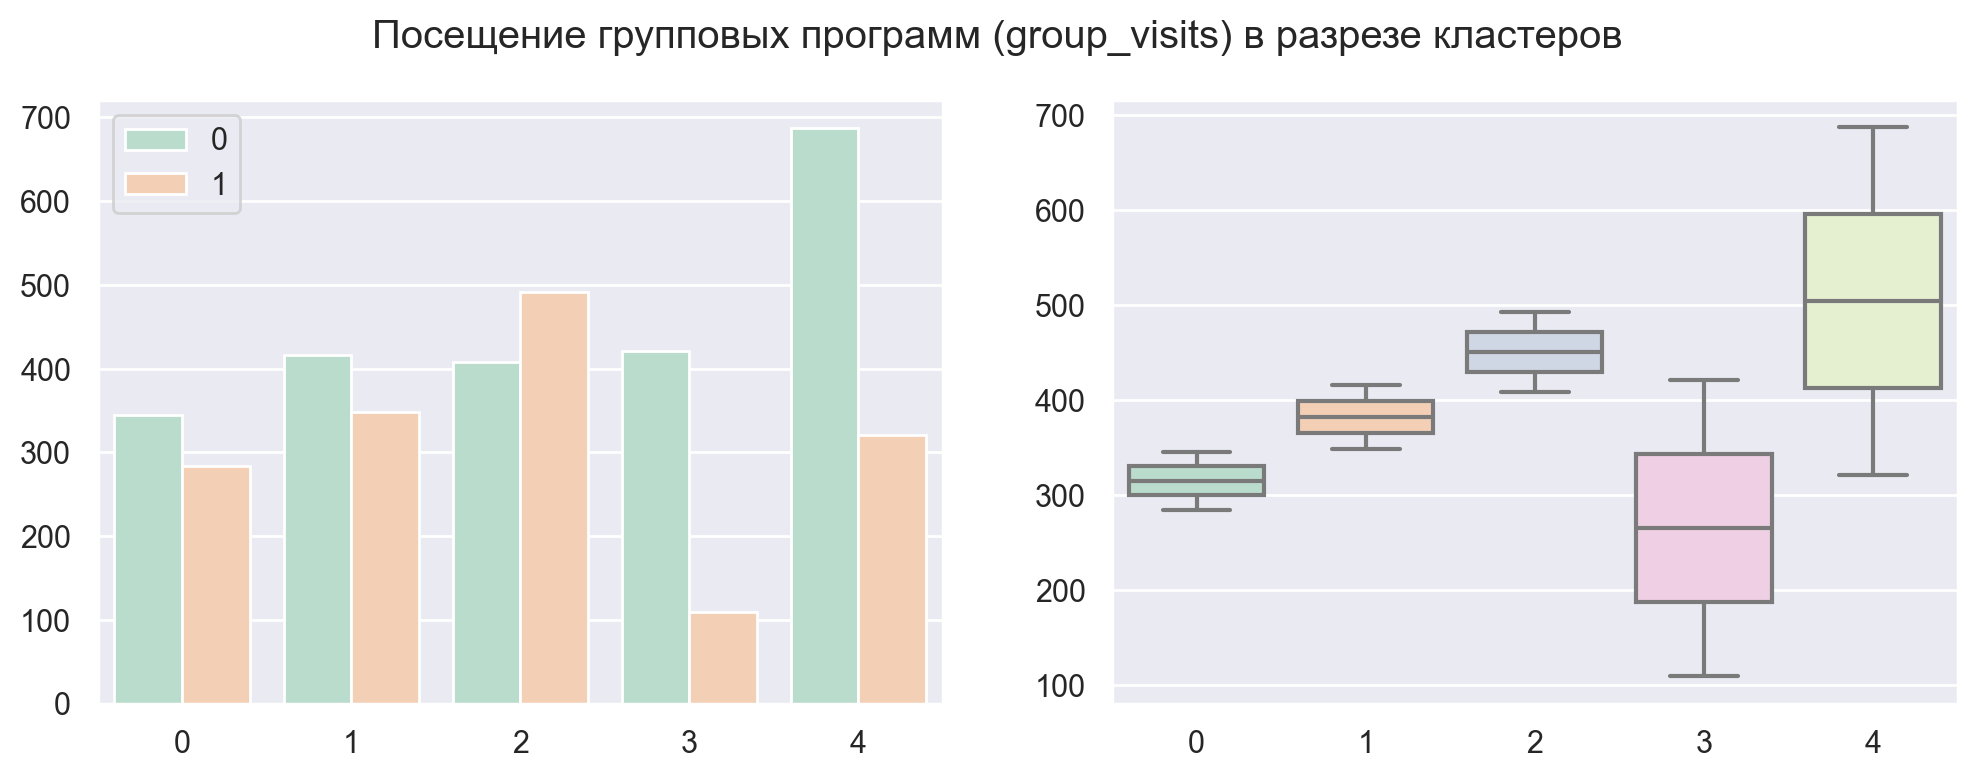

In [27]:
categorical = categorical.query('col not in ["phone", "gender"]')

for index, row in categorical.iterrows():
    cluster_categorical_plots(data, row[0], row[1])

В общем и целом - ничего нового.
  
Надёжные кластеры **№1-2** выделяются более возрастными посетителями , имеющими годовой или 6-месячный абонементы, с высокой степенью вовлеченности (частое и регулярное посещение, дополнительные денежные траты).

Кластеры с высоким оттоком (**№3-4**) состоят  из клиентов, имеющих месячные абонементы, с низкой степенью вовлеченности.

Посмотрим, как распределены клиенты по кластерам:

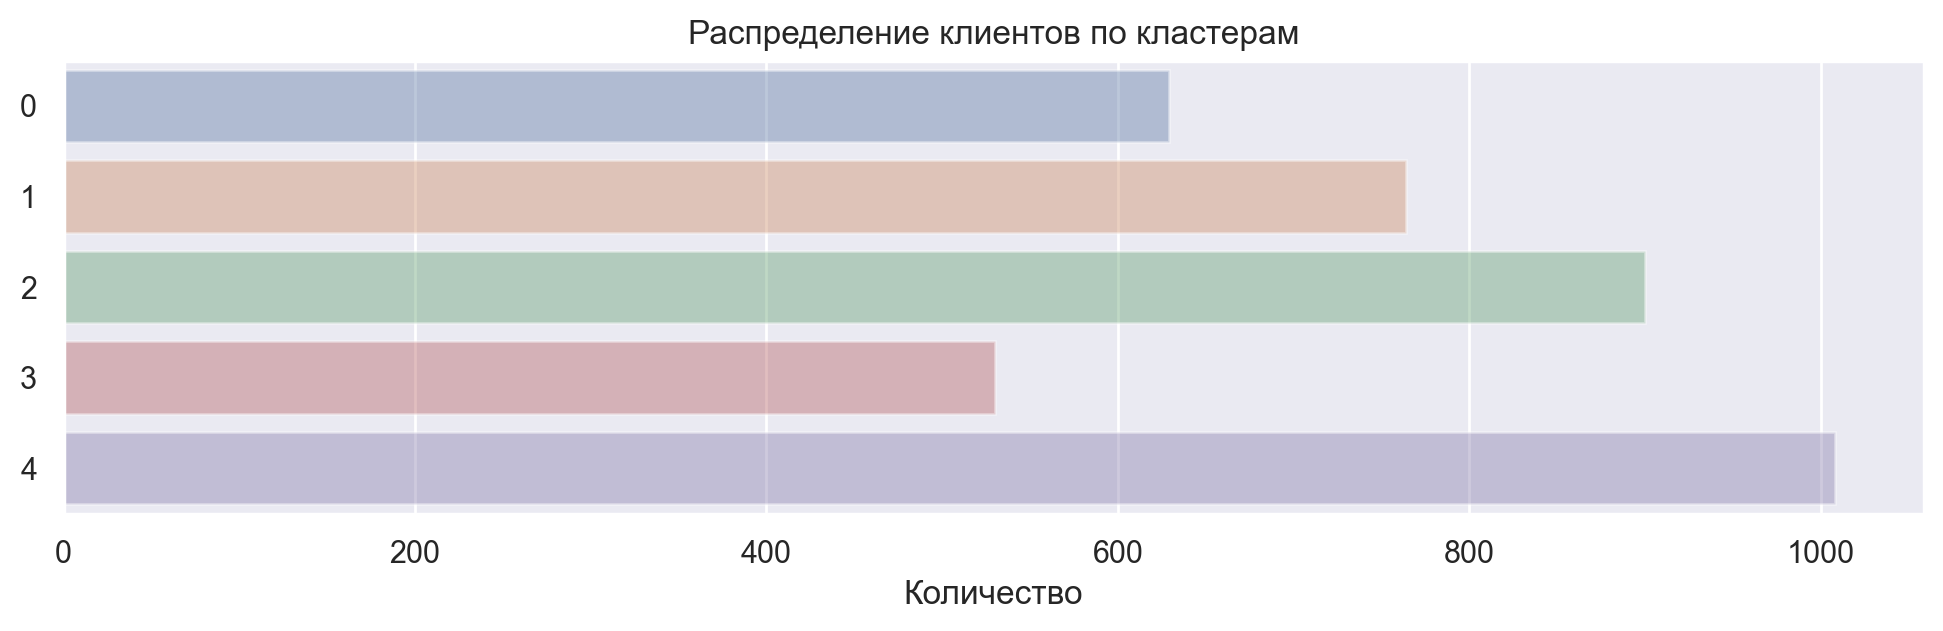

In [28]:
fig, ax = plt.subplots(figsize = (12, 3))
ax = sns.barplot(y='index', 
                 x='cluster_km', 
                 data=data.cluster_km.value_counts().reset_index(), 
                 alpha=0.4, orient='h')
ax.set_title('Распределение клиентов по кластерам')
ax.set_xlabel('Количество') 
ax.set_ylabel('') 
plt.show()

## Выводы и рекомендации

На основе предоставленных заказчиком данных был проведен анализ и подготовить план действий по удержанию клиентов:

**1.** мы научились прогнозировать вероятность оттока клиентов (на уровне следующего месяца для каждого клиента) с результативностью более 90%;

**2.** выявили, что  все распределения признаков обрато пропорциональных вероятности оттока: чем меньше значение параметра, тем вероятнее отток; 

**3.** определили признаки, которые оказывают наибольшее влияние на отток (в порядке убывания важности):
* жизненный цикл клиента `lifetime`;    
* cредняя частоста посещений клуба за последний месяц `avg_class_frequency_current_month`;    
* возраст `age`;     
* срок действующего абонемента `contract_period`;    
* количество месяцев до истечения абонемента `month_to_end_contract`.


**4.** упрощенно поделили всех клиентов  на три ярковыраженные группы:    
1) те, кто имеет высокую вероятность попасть в отток;     
2) те, кто определенно будут и дальше посещать фитнес-клуб;    
3) те, кто потенциально могут присоединиться как к первой, так и ко второй группе;   


**5.** для удобства анализа, мы распределили клиентов на пять кластеров, чтобы выявить пары вида "отточный-надежный" с одинаковыми категорийными признаками.

In [29]:
data.groupby('cluster_km').mean().T

cluster_km,0,1,2,3,4
near_location,1.00,0.98,0.94,0.00,1.00
partner,0.84,0.23,0.74,0.47,0.25
promo_friends,1.00,0.06,0.49,0.08,0.03
contract_period,3.16,2.64,11.87,2.17,1.94
group_visits,0.45,0.46,0.55,0.21,0.32
age,29.21,30.02,29.88,28.45,28.10
avg_additional_charges_total,141.23,155.40,160.59,129.77,127.42
month_to_end_contract,2.92,2.44,10.88,2.04,1.87
lifetime,3.50,4.83,4.52,2.60,2.18
avg_class_frequency_total,1.77,2.63,1.98,1.65,1.21


Представители кластеров №3-4 представляют собой **первую группу клиентов** (с высокой долей оттока). Их характеризуют низкие показатели по всем признакам. Характерная черта: небольшой жизненный цикл, резкий спад количества посещений в текущем месяце по сравнению с предыдущим. Иными словами: люди попробовали (за компанию или из-за близости локации) и не втянулись.

**Вторая группа** характризуется представителями кластеров №1-2, т.е. живут или работают рядом, имеют высокие показатели среди количественных признаков, особенно: большой жизненный цикла, продолжительность срока абонемента и отсутствие разницы между частотой посещения за весь период и за отчетный месяц.

**Третья группа** является целевой для нас (кластер №0). Клиентов именной этой группы необходимо дополнительно замотивировать в первую очередь. С одной стороны, ее представители пользуются близостью локации и используют скидку (сотрудник компании-партнера или  пришли по промо-акции), посещают зал не первый месяц, а 3 и более. При этом среднее количество посещений в неделю начинает проседать.

**6.** по категориальным признакам, кластер №0 схож с надежным кластером №2, поэтому в качестве рекомендации выдвигается предложение простимулировать количественные признаки до показателей, характерных для кластера №2 (в первую очередь - наличие долгосрочного абонемента). 

В качестве вероятных маркетинговых действий клиентам могут быть предложены:
* дополнительные скидки  для сотрудников компаний-партнеров при покупке годового абонемента;    
* мотивационные рассылки;

**7.** дополнительно можно проработать кластер №3 (имеет сходство с кластером №1).

В качестве вероятный мотивирующих действий могут быть предложены:   
* скидки за регулярные посещения;    
* скидки на групповые занятия;
* дополнительный месяц в подарок при регулярных визитах от 2х раз в неделю в течение месяца.
